# GPU

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Fri Jan  8 05:44:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# CFG

In [ ]:
# ====================================================
# CFG
# ====================================================
import json

PROJECT_ID = "kaggle-300711"
TRACKING_URI = 'http://34.74.164.18:5000'
TITLE = '04t-resnext50'
EXPERIMENT_ID = '1'

TAG = {
    'model_name':'resnext50_32x4d',
    'scheduler':'CosineAnnealingWarmRestarts', # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    'criterion':'bi_tempered_logistic_loss'
}

CFG = {
    'debug':False,
    'apex':False,
    'print_freq':100,
    'num_workers':4,
    'size':256,
    'epochs':1000,
    'early_stopping_round':15,
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    #T_max=10 # CosineAnnealingLR
    'T_0':10, # CosineAnnealingWarmRestarts
    'lr':1e-4,
    'min_lr':1e-6,
    'batch_size':32,
    'weight_decay':1e-6,
    'gradient_accumulation_steps':1,
    'max_grad_norm':1000,
    'bi_tempered_loss_t1':0.2,
    'bi_tempered_loss_t2':1.,
    'seed':42,
    'target_size':5,
    'target_col':'label',
    'n_fold':5,
    'trn_fold':[0, 1, 2, 3, 4],
    'train':True,
    'inference':False
}
    
if CFG['debug']:
    CFG['epochs'] = 1

# colab & kaggle notebookでの環境面の処理

## colab

In [ ]:
def _colab_kaggle_authority():
    from googleapiclient.discovery import build
    import io, os
    from googleapiclient.http import MediaIoBaseDownload

    drive_service = build('drive', 'v3')
    results = drive_service.files().list(
            q="name = 'kaggle.json'", fields="files(id)").execute()
    kaggle_api_key = results.get('files', [])

    filename = "/root/.kaggle/kaggle.json"
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
    fh = io.FileIO(filename, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print("Download %d%%." % int(status.progress() * 100))
    os.chmod(filename, 600)


def process_colab():
    import subprocess
    
    # ドライブのマウント
    from google.colab import drive
    drive.mount('/content/drive')

    # Google Cloudの権限設定
    from google.colab import auth
    auth.authenticate_user()

    # kaggle設定
    # _colab_kaggle_authority()
    # subprocess.run('pip install --upgrade --force-reinstall --no-deps kaggle'.split(' '))

    # ライブラリ関係
    subprocess.run('pip install --upgrade opencv-python'.split(' '))
    subprocess.run('pip install --upgrade albumentations'.split(' '))
    subprocess.run('pip install timm'.split(' '))

    # 各種pathの設定
    DATA_PATH = '/content/drive/Shareddrives/便利用/kaggle/cassava/input/'
    OUTPUT_DIR = './output/'
    NOTEBOOK_PATH = f'/content/drive/MyDrive/Colab Notebooks/{TITLE}.ipynb'

    return DATA_PATH, OUTPUT_DIR, NOTEBOOK_PATH

## kaggle notebook

In [ ]:
def _kaggle_gcp_authority():
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    user_credential = user_secrets.get_gcloud_credential()
    user_secrets.set_tensorflow_credential(user_credential)

def process_kaggle():
    # GCP設定
    _kaggle_gcp_authority()

    # 各種pathの設定
    DATA_PATH = '../input/cassava-leaf-disease-classification/'
    OUTPUT_DIR = './'
    NOTEBOOK_PATH = './__notebook__.ipynb'
    # system path
    import sys
    sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

    return DATA_PATH, OUTPUT_DIR, NOTEBOOK_PATH

## 共通

In [ ]:
def process_common():
    # ライブラリ関係
    import subprocess
    subprocess.run('pip install mlflow'.split(' '))

    # 環境変数
    import os
    os.environ["GCLOUD_PROJECT"] = PROJECT_ID

In [ ]:
try:
    from google.colab import auth
except ImportError:
    DATA_PATH, OUTPUT_DIR, NOTEBOOK_PATH = process_kaggle()
else:
    DATA_PATH, OUTPUT_DIR, NOTEBOOK_PATH = process_colab()
finally:
    process_common()

Mounted at /content/drive


# Library

In [ ]:
# ====================================================
# Library
# ====================================================
import os
import datetime
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm
import mlflow

import warnings 
warnings.filterwarnings('ignore')

if CFG['apex']:
    from apex import amp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
start_time = datetime.datetime.now()
start_time_str = start_time.strftime('%m%d%H%M')

# Directory settings

In [ ]:
# ====================================================
# Directory settings
# ====================================================
import os

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# save basic files

In [ ]:
with open(f'{OUTPUT_DIR}/{start_time_str}_TAG.json', 'w') as f:
    json.dump(TAG, f, indent=4)
    
with open(f'{OUTPUT_DIR}/{start_time_str}_CFG.json', 'w') as f:
    json.dump(CFG, f, indent=4)

import shutil
notebook_path = f'{OUTPUT_DIR}/{start_time_str}_{TITLE}.ipynb'
shutil.copy2(NOTEBOOK_PATH, notebook_path)

'./output//01071338_04t-resnext50.ipynb'

# Data Loading

In [ ]:
train = pd.read_csv(f'{DATA_PATH}/train.csv')
test = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')
label_map = pd.read_json(f'{DATA_PATH}/label_num_to_disease_map.json', 
                         orient='index')

if CFG['debug']:
    train = train.sample(n=1000, random_state=CFG['seed']).reset_index(drop=True)

# Utils

In [ ]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger_path = OUTPUT_DIR+f'{start_time_str}_train.log'
LOGGER = init_logger(logger_path)


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG['seed'])


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, save_path='checkpoint.pt',
                 counter=0, best_score=None):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            save_path (str): Directory for saving a model.
                             Default: "'checkpoint.pt'"
        """
        self.patience = patience
        self.verbose = verbose
        self.save_path = save_path
        self.counter = counter
        self.best_score = best_score
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model, preds, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, preds, epoch)
        elif score >= self.best_score:
            self.best_score = score
            self.save_checkpoint(val_loss, model, preds, epoch)
            self.counter = 0
        # nanになったら学習ストップ
        elif math.isnan(score):
            self.early_stop = True
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model, preds, epoch):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.10f} --> {val_loss:.10f}).  Saving model ...')
        torch.save({'model': model.state_dict(), 'preds': preds, 
                    'epoch' : epoch, 'best_score' : self.best_score, 'counter' : self.counter},
                   self.save_path)
        self.val_loss_min = val_loss

In [ ]:
np.nan < 1

False

# CV split

In [ ]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG['n_fold'], shuffle=True, random_state=CFG['seed'])
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG['target_col']])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG['target_col']]).size())

fold  label
0     0         218
      1         438
      2         477
      3        2631
      4         516
1     0         218
      1         438
      2         477
      3        2631
      4         516
2     0         217
      1         438
      2         477
      3        2632
      4         515
3     0         217
      1         438
      2         477
      3        2632
      4         515
4     0         217
      1         437
      2         478
      3        2632
      4         515
dtype: int64


# Dataset

In [ ]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{DATA_PATH}/train_images/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{DATA_PATH}/test_images/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

In [ ]:
# train_dataset = TrainDataset(train, transform=None)

# for i in range(1):
#     image, label = train_dataset[i]
#     plt.imshow(image)
#     plt.title(f'label: {label}')
#     plt.show() 

error: ignored

# Transforms

In [ ]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            #Resize(CFG['size'], CFG['size']),
            RandomResizedCrop(CFG['size'], CFG['size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG['size'], CFG['size']),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

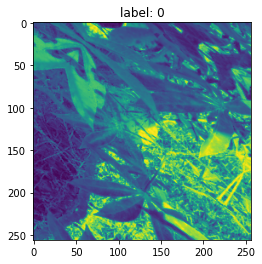

In [ ]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

# Bi-tempered logistic loss

In [ ]:
def log_t(u, t):
    """Compute log_t for `u'."""
    if t==1.0:
        return u.log()
    else:
        return (u.pow(1.0 - t) - 1.0) / (1.0 - t)

def exp_t(u, t):
    """Compute exp_t for `u'."""
    if t==1:
        return u.exp()
    else:
        return (1.0 + (1.0-t)*u).relu().pow(1.0 / (1.0 - t))

def compute_normalization_fixed_point(activations, t, num_iters):

    """Returns the normalization value for each example (t > 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same shape as activation with the last dimension being 1.
    """
    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations_step_0 = activations - mu

    normalized_activations = normalized_activations_step_0

    for _ in range(num_iters):
        logt_partition = torch.sum(
                exp_t(normalized_activations, t), -1, keepdim=True)
        normalized_activations = normalized_activations_step_0 * \
                logt_partition.pow(1.0-t)

    logt_partition = torch.sum(
            exp_t(normalized_activations, t), -1, keepdim=True)
    normalization_constants = - log_t(1.0 / logt_partition, t) + mu

    return normalization_constants

def compute_normalization_binary_search(activations, t, num_iters):

    """Returns the normalization value for each example (t < 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (< 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """

    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations = activations - mu

    effective_dim = \
        torch.sum(
                (normalized_activations > -1.0 / (1.0-t)).to(torch.int32),
            dim=-1, keepdim=True).to(activations.dtype)

    shape_partition = activations.shape[:-1] + (1,)
    lower = torch.zeros(shape_partition, dtype=activations.dtype, device=activations.device)
    upper = -log_t(1.0/effective_dim, t) * torch.ones_like(lower)

    for _ in range(num_iters):
        logt_partition = (upper + lower)/2.0
        sum_probs = torch.sum(
                exp_t(normalized_activations - logt_partition, t),
                dim=-1, keepdim=True)
        update = (sum_probs < 1.0).to(activations.dtype)
        lower = torch.reshape(
                lower * update + (1.0-update) * logt_partition,
                shape_partition)
        upper = torch.reshape(
                upper * (1.0 - update) + update * logt_partition,
                shape_partition)

    logt_partition = (upper + lower)/2.0
    return logt_partition + mu

class ComputeNormalization(torch.autograd.Function):
    """
    Class implementing custom backward pass for compute_normalization. See compute_normalization.
    """
    @staticmethod
    def forward(ctx, activations, t, num_iters):
        if t < 1.0:
            normalization_constants = compute_normalization_binary_search(activations, t, num_iters)
        else:
            normalization_constants = compute_normalization_fixed_point(activations, t, num_iters)

        ctx.save_for_backward(activations, normalization_constants)
        ctx.t=t
        return normalization_constants

    @staticmethod
    def backward(ctx, grad_output):
        activations, normalization_constants = ctx.saved_tensors
        t = ctx.t
        normalized_activations = activations - normalization_constants 
        probabilities = exp_t(normalized_activations, t)
        escorts = probabilities.pow(t)
        escorts = escorts / escorts.sum(dim=-1, keepdim=True)
        grad_input = escorts * grad_output
        
        return grad_input, None, None

def compute_normalization(activations, t, num_iters=5):
    """Returns the normalization value for each example. 
    Backward pass is implemented.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """
    return ComputeNormalization.apply(activations, t, num_iters)

def tempered_sigmoid(activations, t, num_iters = 5):
    """Tempered sigmoid function.
    Args:
      activations: Activations for the positive class for binary classification.
      t: Temperature tensor > 0.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_probabilities = tempered_softmax(internal_activations, t, num_iters)
    return internal_probabilities[..., 0]


def tempered_softmax(activations, t, num_iters=5):
    """Tempered softmax function.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature > 1.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    if t == 1.0:
        return activations.softmax(dim=-1)

    normalization_constants = compute_normalization(activations, t, num_iters)
    return exp_t(activations - normalization_constants, t)

def bi_tempered_binary_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing = 0.0,
        num_iters=5,
        reduction='mean'):

    """Bi-Tempered binary logistic loss.
    Args:
      activations: A tensor containing activations for class 1.
      labels: A tensor with shape as activations, containing probabilities for class 1
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing
      num_iters: Number of iterations to run the method.
    Returns:
      A loss tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_labels = torch.stack([labels.to(activations.dtype),
        1.0 - labels.to(activations.dtype)],
        dim=-1)
    return bi_tempered_logistic_loss(internal_activations, 
            internal_labels,
            t1,
            t2,
            label_smoothing = label_smoothing,
            num_iters = num_iters,
            reduction = reduction)

def bi_tempered_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing=0.0,
        num_iters=5,
        reduction = 'mean'):

    """Bi-Tempered Logistic Loss.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      labels: A tensor with shape and dtype as activations (onehot), 
        or a long tensor of one dimension less than activations (pytorch standard)
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing parameter between [0, 1). Default 0.0.
      num_iters: Number of iterations to run the method. Default 5.
      reduction: ``'none'`` | ``'mean'`` | ``'sum'``. Default ``'mean'``.
        ``'none'``: No reduction is applied, return shape is shape of
        activations without the last dimension.
        ``'mean'``: Loss is averaged over minibatch. Return shape (1,)
        ``'sum'``: Loss is summed over minibatch. Return shape (1,)
    Returns:
      A loss tensor.
    """

    if len(labels.shape)<len(activations.shape): #not one-hot
        labels_onehot = torch.zeros_like(activations)
        labels_onehot.scatter_(1, labels[..., None], 1)
    else:
        labels_onehot = labels

    if label_smoothing > 0:
        num_classes = labels_onehot.shape[-1]
        labels_onehot = ( 1 - label_smoothing * num_classes / (num_classes - 1) ) \
                * labels_onehot + \
                label_smoothing / (num_classes - 1)

    probabilities = tempered_softmax(activations, t2, num_iters)

    loss_values = labels_onehot * log_t(labels_onehot + 1e-10, t1) \
            - labels_onehot * log_t(probabilities, t1) \
            - labels_onehot.pow(2.0 - t1) / (2.0 - t1) \
            + probabilities.pow(2.0 - t1) / (2.0 - t1)
    loss_values = loss_values.sum(dim = -1) #sum over classes

    if reduction == 'none':
        return loss_values
    if reduction == 'sum':
        return loss_values.sum()
    if reduction == 'mean':
        return loss_values.mean()

# MODEL

In [ ]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        if hasattr(self.model, 'classifier'):
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, CFG['target_size'])
        elif hasattr(self.model, 'fc'):
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, CFG['target_size'])

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model = CustomModel(model_name=TAG['model_name'], pretrained=False)
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.1379, -0.0437,  0.0715,  0.2726, -0.0931],
        [ 0.1407,  0.1553,  0.0661,  0.6412,  0.1147],
        [ 0.1008, -0.0071,  0.0307,  0.3932, -0.0678],
        [ 0.1247,  0.0810,  0.0957,  0.5489,  0.1670]],
       grad_fn=<AddmmBackward>)


# Helper functions

In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))




In [ ]:
# ====================================================
# loss
# ====================================================
def get_loss(criterion, y_preds, labels):
    if TAG['criterion']=='CrossEntropyLoss':
        loss = criterion(y_preds, labels)
    elif TAG['criterion'] == 'bi_tempered_logistic_loss':
        loss = criterion(y_preds, labels, t1=CFG['bi_tempered_loss_t1'], t2=CFG['bi_tempered_loss_t2'])
    return loss

In [ ]:
# ====================================================
# Helper functions
# ====================================================
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = get_loss(criterion, y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG['gradient_accumulation_steps'] > 1:
            loss = loss / CFG['gradient_accumulation_steps']
        if CFG['apex']:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG['max_grad_norm'])
        if (step + 1) % CFG['gradient_accumulation_steps'] == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG['print_freq'] == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = get_loss(criterion, y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG['gradient_accumulation_steps'] > 1:
            loss = loss / CFG['gradient_accumulation_steps']
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG['print_freq'] == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            # model.load_state_dict(state['model'])
            model.load_state_dict(state)
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [ ]:
# ====================================================
# scheduler 
# ====================================================
def get_scheduler(optimizer):
    if TAG['scheduler']=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG['factor'], patience=CFG['patience'], verbose=True, eps=CFG['eps'])
    elif TAG['scheduler']=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG['T_max'], eta_min=CFG['min_lr'], last_epoch=-1)
    elif TAG['scheduler']=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
    return scheduler

# ====================================================
# criterion
# ====================================================
def get_criterion():
    if TAG['criterion']=='CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    elif TAG['criterion'] == 'bi_tempered_logistic_loss':
        criterion = bi_tempered_logistic_loss
    return criterion

In [ ]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")
    if not CFG['debug']:
        mlflow.set_tag('running.fold', str(fold))
    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG['batch_size'], 
                              shuffle=True, 
                              num_workers=CFG['num_workers'], pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG['batch_size'], 
                              shuffle=False, 
                              num_workers=CFG['num_workers'], pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer & criterion
    # ====================================================
    model = CustomModel(TAG['model_name'], pretrained=True)
    model.to(device)
    # 学習途中の重みがあれば読み込み
    if os.path.isfile(OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_best.pth'):
        state = torch.load(OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_best.pth')
        model.load_state_dict(state['model'])
        epoch_start = state['epoch']+1
        er_best_score = state['best_score']
        er_counter = state['counter']
        # epoch_start = 10
        # er_best_score = 0
        # er_counter = 1
        LOGGER.info(f'Retrain model in epoch:{epoch_start}, best_score:{er_best_score:.3f}, counter:{er_counter}')
    else:
        epoch_start = 0
        er_best_score = None
        er_counter = 0

    optimizer = Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'], amsgrad=False)
    scheduler = get_scheduler(optimizer)
    criterion = get_criterion()

    # ====================================================
    # apex
    # ====================================================
    if CFG['apex']:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    # ====================================================
    # loop
    # ====================================================
    # best_score = 0.
    # best_loss = np.inf
    
    early_stopping = EarlyStopping(
                            patience=CFG['early_stopping_round'], 
                            verbose=False,
                            save_path=OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_best.pth',
                            counter=er_counter, best_score=er_best_score)
    
    for epoch in range(epoch_start, CFG['epochs']):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG['target_col']].values
        
        # early stopping
        early_stopping(avg_val_loss, model, preds, epoch)
        if early_stopping.early_stop:
            print(f'Epoch {epoch+1} - early stopping')
            break
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')
        
        # log mlflow
        if not CFG['debug']:
            mlflow.log_metric(f"fold{fold} avg_train_loss", avg_loss, step=epoch)
            mlflow.log_metric(f"fold{fold} avg_valid_loss", avg_val_loss, step=epoch)
            mlflow.log_metric(f"fold{fold} score", score, step=epoch)
            mlflow.log_metric(f"fold{fold} lr", scheduler.get_last_lr()[0], step=epoch)
            mlflow.log_artifact(OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_best.pth')
    valid_folds[[str(c) for c in range(5)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds

In [ ]:
# ====================================================
# main
# ====================================================
def get_result(result_df):
    preds = result_df['preds'].values
    labels = result_df[CFG['target_col']].values
    score = get_score(labels, preds)
    LOGGER.info(f'Score: {score:<.5f}')
    
    return score

    

def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """
    
    if CFG['train']:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG['n_fold']):
            if fold in CFG['trn_fold']:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                _ = get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        score = get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
        # log mlflow
        if not CFG['debug']:
            mlflow.log_metric('oof score', score)
            mlflow.delete_tag('running.fold')
            mlflow.log_artifact(OUTPUT_DIR+'oof_df.csv')
    
    if CFG['inference']:
        # inference
        model = CustomModel(TAG['model_name'], pretrained=False)
        states = [torch.load(OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_best.pth') for fold in CFG['trn_fold']]
        test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG['batch_size'], shuffle=False, 
                                 num_workers=CFG['num_workers'], pin_memory=True)
        predictions = inference(model, states, test_loader, device)
        # submission
        test['label'] = predictions.argmax(1)
        test[['image_id', 'label']].to_csv(OUTPUT_DIR+'submission.csv', index=False)

# rerun

In [ ]:
def _load_save_point(run_id):
    # どこで中断したか取得
    # stop_fold = int(mlflow.get_run(run_id=run_id).to_dictionary()['data']['tags']['running.fold'])
    stop_fold = 1
    # 学習対象のfoldを変更
    CFG['trn_fold'] = [fold for fold in CFG['trn_fold'] if fold>=stop_fold]
    # 学習済みモデルがあれば.pthファイルを取得(学習中も含む)
    client = mlflow.tracking.MlflowClient()
    artifacts = [artifact for artifact in client.list_artifacts(run_id) if ".pth" in artifact.path]
    for artifact in artifacts:
        client.download_artifacts(run_id, artifact.path, OUTPUT_DIR)

    os.remove('/content/output/resnext50_32x4d_fold1_best.pth')
    os.remove('/content/output/resnext50_32x4d_fold2_best.pth')

def check_have_run():
    results = mlflow.search_runs(EXPERIMENT_ID)
    run_id_list = results[results['tags.mlflow.runName']==TITLE]['run_id'].tolist()
    # 初めて実行する場合
    if len(run_id_list) == 0:
        run_id = None
    # 既に実行されている場合
    else:
        assert len(run_id_list)==1
        run_id = run_id_list[0]
        _load_save_point(run_id)

    return run_id

In [ ]:
if __name__ == '__main__':
    if CFG['debug']:
        main()
    else:
        mlflow.set_tracking_uri(TRACKING_URI)
        mlflow.set_experiment('single model')
        # 既に実行済みの場合は続きから実行する
        run_id = check_have_run()
        with mlflow.start_run(run_id=run_id, run_name=TITLE):
            if run_id is None:
                mlflow.set_tags(TAG)
                mlflow.log_params(CFG)
                mlflow.log_artifacts(OUTPUT_DIR)
                # mlflow.log_dict(TAG, "TAG.yml")
                # mlflow.log_dict(CFG, "CFG.yml")
                mlflow.log_param('device', device)
            main()
            mlflow.log_artifacts(OUTPUT_DIR)

========== fold: 1 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnext50_32x4d_ra-d733960d.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d_ra-d733960d.pth


Epoch: [1][0/534] Data 21.821 (21.821) Elapsed 0m 22s (remain 197m 43s) Loss: 0.4700(0.4700) Grad: 2.2793  
Epoch: [1][100/534] Data 19.177 (5.814) Elapsed 10m 22s (remain 44m 27s) Loss: 0.1511(0.2533) Grad: 2.6979  
Epoch: [1][200/534] Data 0.000 (5.804) Elapsed 20m 36s (remain 34m 8s) Loss: 0.2246(0.2292) Grad: 2.6319  
Epoch: [1][300/534] Data 0.000 (5.893) Elapsed 31m 18s (remain 24m 14s) Loss: 0.1552(0.2123) Grad: 2.2764  
Epoch: [1][400/534] Data 0.000 (5.961) Elapsed 42m 9s (remain 13m 58s) Loss: 0.1524(0.2031) Grad: 3.1292  
Epoch: [1][500/534] Data 5.955 (5.968) Elapsed 52m 43s (remain 3m 28s) Loss: 0.2289(0.1968) Grad: 1.7362  
Epoch: [1][533/534] Data 0.000 (5.966) Elapsed 56m 11s (remain 0m 0s) Loss: 0.2129(0.1944) Grad: 1.9643  
EVAL: [0/134] Data 24.143 (24.143) Elapsed 0m 24s (remain 53m 43s) Loss: 0.1838(0.1838) 
EVAL: [100/134] Data 13.466 (6.482) Elapsed 11m 4s (remain 3m 36s) Loss: 0.1962(0.1510) 
EVAL: [133/134] Data 9.111 (6.423) Elapsed 14m 33s (remain 0m 0s) Loss

Epoch 1 - avg_train_loss: 0.1944  avg_val_loss: 0.1507  time: 4245s
Epoch 1 - Accuracy: 0.8299065420560747


Epoch: [2][0/534] Data 1.356 (1.356) Elapsed 0m 1s (remain 16m 6s) Loss: 0.1089(0.1089) Grad: 1.4611  
Epoch: [2][100/534] Data 0.000 (0.016) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1819(0.1579) Grad: 1.9260  
Epoch: [2][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.0982(0.1562) Grad: 2.1236  
Epoch: [2][300/534] Data 0.000 (0.006) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1294(0.1546) Grad: 1.7631  
Epoch: [2][400/534] Data 0.000 (0.005) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1168(0.1554) Grad: 1.3599  
Epoch: [2][500/534] Data 0.000 (0.004) Elapsed 3m 19s (remain 0m 13s) Loss: 0.1242(0.1547) Grad: 1.5406  
Epoch: [2][533/534] Data 0.000 (0.004) Elapsed 3m 32s (remain 0m 0s) Loss: 0.1952(0.1542) Grad: 2.4808  
EVAL: [0/134] Data 1.347 (1.347) Elapsed 0m 1s (remain 3m 14s) Loss: 0.0956(0.0956) 
EVAL: [100/134] Data 0.804 (0.211) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1303(0.1344) 
EVAL: [133/134] Data 0.000 (0.199) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0582(0.1345) 


Epoch 2 - avg_train_loss: 0.1542  avg_val_loss: 0.1345  time: 252s
Epoch 2 - Accuracy: 0.8502336448598131


Epoch: [3][0/534] Data 1.477 (1.477) Elapsed 0m 1s (remain 16m 59s) Loss: 0.2008(0.2008) Grad: 2.4330  
Epoch: [3][100/534] Data 0.000 (0.015) Elapsed 0m 41s (remain 2m 58s) Loss: 0.1866(0.1373) Grad: 1.8143  
Epoch: [3][200/534] Data 0.000 (0.008) Elapsed 1m 20s (remain 2m 13s) Loss: 0.1574(0.1406) Grad: 1.3151  
Epoch: [3][300/534] Data 0.001 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.0439(0.1433) Grad: 0.6872  
Epoch: [3][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.2388(0.1445) Grad: 2.4224  
Epoch: [3][500/534] Data 0.000 (0.004) Elapsed 3m 19s (remain 0m 13s) Loss: 0.1452(0.1448) Grad: 1.3589  
Epoch: [3][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.1957(0.1439) Grad: 2.1506  
EVAL: [0/134] Data 1.367 (1.367) Elapsed 0m 1s (remain 3m 14s) Loss: 0.1294(0.1294) 
EVAL: [100/134] Data 0.382 (0.208) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1047(0.1307) 
EVAL: [133/134] Data 0.000 (0.200) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0409(0.1305) 


Epoch 3 - avg_train_loss: 0.1439  avg_val_loss: 0.1305  time: 252s
Epoch 3 - Accuracy: 0.8521028037383177


Epoch: [4][0/534] Data 1.339 (1.339) Elapsed 0m 1s (remain 15m 48s) Loss: 0.1272(0.1272) Grad: 1.7135  
Epoch: [4][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 58s) Loss: 0.0902(0.1376) Grad: 2.0682  
Epoch: [4][200/534] Data 0.001 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1180(0.1381) Grad: 1.2406  
Epoch: [4][300/534] Data 0.001 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.2255(0.1369) Grad: 1.9867  
Epoch: [4][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 53s) Loss: 0.0853(0.1353) Grad: 1.1972  
Epoch: [4][500/534] Data 0.000 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.1857(0.1356) Grad: 1.4232  
Epoch: [4][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.2922(0.1357) Grad: 2.3891  
EVAL: [0/134] Data 1.089 (1.089) Elapsed 0m 1s (remain 2m 37s) Loss: 0.0837(0.0837) 
EVAL: [100/134] Data 0.119 (0.202) Elapsed 0m 30s (remain 0m 9s) Loss: 0.1180(0.1160) 
EVAL: [133/134] Data 0.016 (0.198) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0197(0.1186) 


Epoch 4 - avg_train_loss: 0.1357  avg_val_loss: 0.1186  time: 252s
Epoch 4 - Accuracy: 0.8689252336448599


Epoch: [5][0/534] Data 1.363 (1.363) Elapsed 0m 1s (remain 16m 21s) Loss: 0.1641(0.1641) Grad: 2.0696  
Epoch: [5][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 56s) Loss: 0.2075(0.1296) Grad: 1.2728  
Epoch: [5][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.1676(0.1258) Grad: 1.8051  
Epoch: [5][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.1843(0.1272) Grad: 2.4322  
Epoch: [5][400/534] Data 0.005 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.1064(0.1263) Grad: 1.4016  
Epoch: [5][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.1350(0.1279) Grad: 2.6140  
Epoch: [5][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.1198(0.1282) Grad: 1.8396  
EVAL: [0/134] Data 1.380 (1.380) Elapsed 0m 1s (remain 3m 16s) Loss: 0.0681(0.0681) 
EVAL: [100/134] Data 0.531 (0.208) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1306(0.1165) 
EVAL: [133/134] Data 0.000 (0.200) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0058(0.1139) 


Epoch 5 - avg_train_loss: 0.1282  avg_val_loss: 0.1139  time: 251s
Epoch 5 - Accuracy: 0.8700934579439252


Epoch: [6][0/534] Data 1.232 (1.232) Elapsed 0m 1s (remain 14m 49s) Loss: 0.0743(0.0743) Grad: 1.2354  
Epoch: [6][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 58s) Loss: 0.1099(0.1254) Grad: 1.2637  
Epoch: [6][200/534] Data 0.002 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1263(0.1254) Grad: 1.6547  
Epoch: [6][300/534] Data 0.001 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.0944(0.1256) Grad: 1.1724  
Epoch: [6][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 53s) Loss: 0.1113(0.1240) Grad: 1.3344  
Epoch: [6][500/534] Data 0.005 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.1301(0.1233) Grad: 2.0009  
Epoch: [6][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.0502(0.1226) Grad: 0.4873  
EVAL: [0/134] Data 1.341 (1.341) Elapsed 0m 1s (remain 3m 11s) Loss: 0.0856(0.0856) 
EVAL: [100/134] Data 0.309 (0.207) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1340(0.1113) 
EVAL: [133/134] Data 0.035 (0.199) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0097(0.1099) 


Epoch 6 - avg_train_loss: 0.1226  avg_val_loss: 0.1099  time: 252s
Epoch 6 - Accuracy: 0.8801401869158878


Epoch: [7][0/534] Data 1.240 (1.240) Elapsed 0m 1s (remain 14m 34s) Loss: 0.1485(0.1485) Grad: 1.7441  
Epoch: [7][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 58s) Loss: 0.1624(0.1161) Grad: 1.3080  
Epoch: [7][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1257(0.1128) Grad: 1.5828  
Epoch: [7][300/534] Data 0.006 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.0887(0.1142) Grad: 1.5927  
Epoch: [7][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1145(0.1141) Grad: 2.2081  
Epoch: [7][500/534] Data 0.000 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.0930(0.1159) Grad: 1.1612  
Epoch: [7][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.2238(0.1159) Grad: 1.9329  
EVAL: [0/134] Data 1.184 (1.184) Elapsed 0m 1s (remain 2m 50s) Loss: 0.0792(0.0792) 
EVAL: [100/134] Data 0.005 (0.206) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1188(0.1114) 


Epoch 7 - avg_train_loss: 0.1159  avg_val_loss: 0.1112  time: 252s
Epoch 7 - Accuracy: 0.8782710280373832


EVAL: [133/134] Data 0.033 (0.199) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0075(0.1112) 
Epoch: [8][0/534] Data 1.425 (1.425) Elapsed 0m 1s (remain 16m 47s) Loss: 0.1630(0.1630) Grad: 1.0483  
Epoch: [8][100/534] Data 0.000 (0.015) Elapsed 0m 41s (remain 2m 59s) Loss: 0.0742(0.1151) Grad: 1.0850  
Epoch: [8][200/534] Data 0.005 (0.008) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1022(0.1132) Grad: 1.6719  
Epoch: [8][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1285(0.1099) Grad: 1.2387  
Epoch: [8][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0346(0.1096) Grad: 0.7532  
Epoch: [8][500/534] Data 0.000 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.1541(0.1097) Grad: 1.8676  
Epoch: [8][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.1218(0.1106) Grad: 1.1951  
EVAL: [0/134] Data 1.270 (1.270) Elapsed 0m 1s (remain 3m 2s) Loss: 0.0788(0.0788) 
EVAL: [100/134] Data 0.000 (0.204) Elapsed 0m 30s (remain 0m 9s) Loss: 0.1201(0.1090) 
EVAL

Epoch 8 - avg_train_loss: 0.1106  avg_val_loss: 0.1071  time: 252s
Epoch 8 - Accuracy: 0.8829439252336448


Epoch: [9][0/534] Data 1.381 (1.381) Elapsed 0m 1s (remain 16m 22s) Loss: 0.0822(0.0822) Grad: 1.3558  
Epoch: [9][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 58s) Loss: 0.0909(0.1102) Grad: 1.5052  
Epoch: [9][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 14s) Loss: 0.0697(0.1086) Grad: 1.5447  
Epoch: [9][300/534] Data 0.001 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1574(0.1066) Grad: 1.3948  
Epoch: [9][400/534] Data 0.002 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0901(0.1048) Grad: 1.7902  
Epoch: [9][500/534] Data 0.000 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.1461(0.1051) Grad: 1.3854  
Epoch: [9][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.0847(0.1042) Grad: 1.2459  
EVAL: [0/134] Data 1.258 (1.258) Elapsed 0m 1s (remain 3m 0s) Loss: 0.0759(0.0759) 
EVAL: [100/134] Data 0.350 (0.210) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1126(0.1066) 
EVAL: [133/134] Data 0.000 (0.201) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0033(0.1064) 


Epoch 9 - avg_train_loss: 0.1042  avg_val_loss: 0.1064  time: 253s
Epoch 9 - Accuracy: 0.8864485981308411


Epoch: [10][0/534] Data 1.255 (1.255) Elapsed 0m 1s (remain 15m 16s) Loss: 0.1058(0.1058) Grad: 1.4490  
Epoch: [10][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 58s) Loss: 0.1014(0.1107) Grad: 1.0533  
Epoch: [10][200/534] Data 0.001 (0.007) Elapsed 1m 20s (remain 2m 14s) Loss: 0.0918(0.1033) Grad: 1.6996  
Epoch: [10][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.0954(0.1021) Grad: 2.0028  
Epoch: [10][400/534] Data 0.001 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.0613(0.1014) Grad: 1.5393  
Epoch: [10][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.1092(0.1017) Grad: 1.2359  
Epoch: [10][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.2152(0.1025) Grad: 2.1771  
EVAL: [0/134] Data 1.461 (1.461) Elapsed 0m 1s (remain 3m 27s) Loss: 0.0687(0.0687) 
EVAL: [100/134] Data 0.846 (0.211) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1136(0.1059) 
EVAL: [133/134] Data 0.000 (0.199) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0028(0.10

Epoch 10 - avg_train_loss: 0.1025  avg_val_loss: 0.1052  time: 252s
Epoch 10 - Accuracy: 0.8869158878504673


Epoch: [11][0/534] Data 1.470 (1.470) Elapsed 0m 1s (remain 16m 52s) Loss: 0.1081(0.1081) Grad: 1.3067  
Epoch: [11][100/534] Data 0.000 (0.015) Elapsed 0m 41s (remain 2m 58s) Loss: 0.1020(0.1111) Grad: 1.6788  
Epoch: [11][200/534] Data 0.001 (0.008) Elapsed 1m 20s (remain 2m 13s) Loss: 0.0832(0.1177) Grad: 1.3516  
Epoch: [11][300/534] Data 0.000 (0.006) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1316(0.1219) Grad: 2.4948  
Epoch: [11][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.1077(0.1245) Grad: 1.2873  
Epoch: [11][500/534] Data 0.000 (0.004) Elapsed 3m 18s (remain 0m 13s) Loss: 0.0807(0.1256) Grad: 1.0954  
Epoch: [11][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.0951(0.1263) Grad: 1.0768  
EVAL: [0/134] Data 1.382 (1.382) Elapsed 0m 1s (remain 3m 16s) Loss: 0.1275(0.1275) 
EVAL: [100/134] Data 0.840 (0.215) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1187(0.1205) 


Epoch 11 - avg_train_loss: 0.1263  avg_val_loss: 0.1174  time: 252s
Epoch 11 - Accuracy: 0.8698598130841122


EVAL: [133/134] Data 0.000 (0.200) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0340(0.1174) 
Epoch: [12][0/534] Data 1.271 (1.271) Elapsed 0m 1s (remain 15m 18s) Loss: 0.1908(0.1908) Grad: 1.3402  
Epoch: [12][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 57s) Loss: 0.1484(0.1290) Grad: 1.5056  
Epoch: [12][200/534] Data 0.003 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.1862(0.1258) Grad: 1.4373  
Epoch: [12][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.0757(0.1256) Grad: 1.3029  
Epoch: [12][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.0579(0.1259) Grad: 1.2637  
Epoch: [12][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.0510(0.1250) Grad: 0.8087  
Epoch: [12][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.0554(0.1252) Grad: 0.7614  
EVAL: [0/134] Data 1.134 (1.134) Elapsed 0m 1s (remain 2m 44s) Loss: 0.0710(0.0710) 
EVAL: [100/134] Data 0.592 (0.207) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1238(0.1

Epoch 12 - avg_train_loss: 0.1252  avg_val_loss: 0.1195  time: 252s
Epoch 12 - Accuracy: 0.8677570093457944


EVAL: [133/134] Data 0.036 (0.201) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0115(0.1195) 
Epoch: [13][0/534] Data 1.556 (1.556) Elapsed 0m 2s (remain 17m 47s) Loss: 0.1350(0.1350) Grad: 0.8681  
Epoch: [13][100/534] Data 0.000 (0.016) Elapsed 0m 41s (remain 2m 58s) Loss: 0.0629(0.1241) Grad: 1.0886  
Epoch: [13][200/534] Data 0.000 (0.008) Elapsed 1m 20s (remain 2m 13s) Loss: 0.1359(0.1173) Grad: 1.3280  
Epoch: [13][300/534] Data 0.000 (0.006) Elapsed 1m 59s (remain 1m 32s) Loss: 0.1110(0.1164) Grad: 1.5127  
Epoch: [13][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.0798(0.1174) Grad: 1.3259  
Epoch: [13][500/534] Data 0.000 (0.004) Elapsed 3m 18s (remain 0m 13s) Loss: 0.1121(0.1199) Grad: 1.0541  
Epoch: [13][533/534] Data 0.000 (0.004) Elapsed 3m 31s (remain 0m 0s) Loss: 0.1888(0.1194) Grad: 1.2809  
EVAL: [0/134] Data 1.449 (1.449) Elapsed 0m 1s (remain 3m 25s) Loss: 0.0813(0.0813) 
EVAL: [100/134] Data 0.617 (0.212) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1168(0.1

Epoch 13 - avg_train_loss: 0.1194  avg_val_loss: 0.1113  time: 251s
Epoch 13 - Accuracy: 0.8787383177570094


EVAL: [133/134] Data 0.000 (0.202) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0073(0.1113) 
Epoch: [14][0/534] Data 1.512 (1.512) Elapsed 0m 1s (remain 17m 25s) Loss: 0.1320(0.1320) Grad: 1.6475  
Epoch: [14][100/534] Data 0.005 (0.015) Elapsed 0m 41s (remain 2m 58s) Loss: 0.2403(0.1167) Grad: 1.7086  
Epoch: [14][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1577(0.1181) Grad: 1.2000  
Epoch: [14][300/534] Data 0.017 (0.006) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1093(0.1186) Grad: 1.1139  
Epoch: [14][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1555(0.1188) Grad: 1.3367  
Epoch: [14][500/534] Data 0.005 (0.004) Elapsed 3m 19s (remain 0m 13s) Loss: 0.0492(0.1180) Grad: 1.4627  
Epoch: [14][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.1655(0.1169) Grad: 1.2326  
EVAL: [0/134] Data 1.273 (1.273) Elapsed 0m 1s (remain 3m 2s) Loss: 0.1052(0.1052) 
EVAL: [100/134] Data 0.843 (0.213) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1106(0.111

Epoch 14 - avg_train_loss: 0.1169  avg_val_loss: 0.1113  time: 252s
Epoch 14 - Accuracy: 0.8796728971962616


EVAL: [133/134] Data 0.000 (0.201) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0128(0.1113) 
Epoch: [15][0/534] Data 1.579 (1.579) Elapsed 0m 2s (remain 18m 6s) Loss: 0.0389(0.0389) Grad: 0.9584  
Epoch: [15][100/534] Data 0.000 (0.016) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1191(0.1143) Grad: 1.8524  
Epoch: [15][200/534] Data 0.003 (0.008) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1024(0.1094) Grad: 1.1159  
Epoch: [15][300/534] Data 0.000 (0.006) Elapsed 2m 0s (remain 1m 33s) Loss: 0.0600(0.1085) Grad: 1.1599  
Epoch: [15][400/534] Data 0.002 (0.005) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1125(0.1101) Grad: 1.0017  
Epoch: [15][500/534] Data 0.000 (0.004) Elapsed 3m 19s (remain 0m 13s) Loss: 0.0695(0.1091) Grad: 1.4633  
Epoch: [15][533/534] Data 0.000 (0.004) Elapsed 3m 32s (remain 0m 0s) Loss: 0.1644(0.1101) Grad: 1.4705  
EVAL: [0/134] Data 1.334 (1.334) Elapsed 0m 1s (remain 3m 10s) Loss: 0.0707(0.0707) 
EVAL: [100/134] Data 0.729 (0.208) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1164(0.108

Epoch 15 - avg_train_loss: 0.1101  avg_val_loss: 0.1090  time: 252s
Epoch 15 - Accuracy: 0.8815420560747663


EVAL: [133/134] Data 0.000 (0.199) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0056(0.1090) 
Epoch: [16][0/534] Data 1.249 (1.249) Elapsed 0m 1s (remain 15m 8s) Loss: 0.1033(0.1033) Grad: 1.5838  
Epoch: [16][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 57s) Loss: 0.0996(0.1068) Grad: 1.3406  
Epoch: [16][200/534] Data 0.001 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.1067(0.1055) Grad: 1.6311  
Epoch: [16][300/534] Data 0.003 (0.005) Elapsed 2m 0s (remain 1m 32s) Loss: 0.1309(0.1064) Grad: 1.5126  
Epoch: [16][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.0342(0.1060) Grad: 1.1105  
Epoch: [16][500/534] Data 0.000 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.1001(0.1065) Grad: 1.2452  
Epoch: [16][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.0978(0.1059) Grad: 1.6111  
EVAL: [0/134] Data 1.392 (1.392) Elapsed 0m 1s (remain 3m 18s) Loss: 0.0743(0.0743) 
EVAL: [100/134] Data 0.000 (0.204) Elapsed 0m 30s (remain 0m 9s) Loss: 0.0946(0.1064

Epoch 16 - avg_train_loss: 0.1059  avg_val_loss: 0.1071  time: 251s
Epoch 16 - Accuracy: 0.8864485981308411


EVAL: [133/134] Data 0.000 (0.196) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0063(0.1071) 
Epoch: [17][0/534] Data 1.502 (1.502) Elapsed 0m 1s (remain 17m 18s) Loss: 0.0907(0.0907) Grad: 1.8306  
Epoch: [17][100/534] Data 0.000 (0.016) Elapsed 0m 41s (remain 2m 57s) Loss: 0.0350(0.1081) Grad: 1.0435  
Epoch: [17][200/534] Data 0.000 (0.008) Elapsed 1m 20s (remain 2m 12s) Loss: 0.1139(0.1043) Grad: 1.3829  
Epoch: [17][300/534] Data 0.001 (0.006) Elapsed 1m 59s (remain 1m 32s) Loss: 0.1663(0.1043) Grad: 1.2514  
Epoch: [17][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.1371(0.1021) Grad: 1.9236  
Epoch: [17][500/534] Data 0.000 (0.004) Elapsed 3m 18s (remain 0m 13s) Loss: 0.1010(0.1015) Grad: 1.6025  
Epoch: [17][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.1172(0.1019) Grad: 1.5511  
EVAL: [0/134] Data 1.443 (1.443) Elapsed 0m 1s (remain 3m 24s) Loss: 0.0807(0.0807) 
EVAL: [100/134] Data 0.186 (0.207) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1076(0.1

Epoch 17 - avg_train_loss: 0.1019  avg_val_loss: 0.1085  time: 251s
Epoch 17 - Accuracy: 0.8817757009345795


EVAL: [133/134] Data 0.011 (0.202) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0056(0.1085) 
Epoch: [18][0/534] Data 1.265 (1.265) Elapsed 0m 1s (remain 15m 43s) Loss: 0.0625(0.0625) Grad: 1.2880  
Epoch: [18][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1135(0.0947) Grad: 1.5755  
Epoch: [18][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1176(0.0924) Grad: 1.5755  
Epoch: [18][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1098(0.0936) Grad: 0.6462  
Epoch: [18][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0243(0.0946) Grad: 0.8482  
Epoch: [18][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0912(0.0942) Grad: 1.5409  
Epoch: [18][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.0453(0.0935) Grad: 1.4298  
EVAL: [0/134] Data 1.412 (1.412) Elapsed 0m 1s (remain 3m 20s) Loss: 0.0695(0.0695) 
EVAL: [100/134] Data 0.528 (0.212) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1035(0.10

Epoch 18 - avg_train_loss: 0.0935  avg_val_loss: 0.1071  time: 253s
Epoch 18 - Accuracy: 0.8848130841121495


EVAL: [133/134] Data 0.000 (0.203) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0039(0.1071) 
Epoch: [19][0/534] Data 1.162 (1.162) Elapsed 0m 1s (remain 14m 26s) Loss: 0.0077(0.0077) Grad: 0.4307  
Epoch: [19][100/534] Data 0.001 (0.013) Elapsed 0m 41s (remain 2m 58s) Loss: 0.1286(0.0854) Grad: 1.0451  
Epoch: [19][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1278(0.0863) Grad: 1.3621  
Epoch: [19][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.0942(0.0866) Grad: 1.6926  
Epoch: [19][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0758(0.0876) Grad: 1.5147  
Epoch: [19][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0606(0.0870) Grad: 2.1024  
Epoch: [19][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.0448(0.0881) Grad: 1.2447  
EVAL: [0/134] Data 1.412 (1.412) Elapsed 0m 1s (remain 3m 20s) Loss: 0.0707(0.0707) 
EVAL: [100/134] Data 0.000 (0.209) Elapsed 0m 30s (remain 0m 10s) Loss: 0.0839(0.10

Epoch 19 - avg_train_loss: 0.0881  avg_val_loss: 0.1071  time: 253s
Epoch 19 - Accuracy: 0.8820093457943925


EVAL: [133/134] Data 0.000 (0.201) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0041(0.1071) 
Epoch: [20][0/534] Data 1.257 (1.257) Elapsed 0m 1s (remain 15m 16s) Loss: 0.0488(0.0488) Grad: 1.0328  
Epoch: [20][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 58s) Loss: 0.0241(0.0835) Grad: 0.8619  
Epoch: [20][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.0830(0.0853) Grad: 1.4822  
Epoch: [20][300/534] Data 0.002 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.0600(0.0866) Grad: 1.3141  
Epoch: [20][400/534] Data 0.007 (0.004) Elapsed 2m 39s (remain 0m 53s) Loss: 0.0888(0.0887) Grad: 0.8997  
Epoch: [20][500/534] Data 0.000 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.1102(0.0885) Grad: 1.4274  
Epoch: [20][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.0659(0.0880) Grad: 1.7491  
EVAL: [0/134] Data 1.486 (1.486) Elapsed 0m 1s (remain 3m 29s) Loss: 0.0755(0.0755) 
EVAL: [100/134] Data 0.595 (0.209) Elapsed 0m 30s (remain 0m 10s) Loss: 0.0851(0.10

Epoch 20 - avg_train_loss: 0.0880  avg_val_loss: 0.1067  time: 252s
Epoch 20 - Accuracy: 0.8817757009345795


EVAL: [133/134] Data 0.000 (0.203) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0029(0.1067) 
Epoch: [21][0/534] Data 1.349 (1.349) Elapsed 0m 1s (remain 15m 51s) Loss: 0.0782(0.0782) Grad: 1.1992  
Epoch: [21][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 59s) Loss: 0.0974(0.1112) Grad: 1.4856  
Epoch: [21][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1576(0.1107) Grad: 1.0177  
Epoch: [21][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1427(0.1104) Grad: 1.6315  
Epoch: [21][400/534] Data 0.002 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1330(0.1134) Grad: 1.2250  
Epoch: [21][500/534] Data 0.000 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.0951(0.1136) Grad: 1.0798  
Epoch: [21][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.0739(0.1126) Grad: 1.0836  
EVAL: [0/134] Data 1.289 (1.289) Elapsed 0m 1s (remain 3m 5s) Loss: 0.1227(0.1227) 
EVAL: [100/134] Data 0.848 (0.215) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1214(0.118

Epoch 21 - avg_train_loss: 0.1126  avg_val_loss: 0.1198  time: 252s
Epoch 21 - Accuracy: 0.8651869158878505


EVAL: [133/134] Data 0.000 (0.202) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0098(0.1198) 
Epoch: [22][0/534] Data 1.346 (1.346) Elapsed 0m 1s (remain 15m 56s) Loss: 0.0802(0.0802) Grad: 1.8990  
Epoch: [22][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 59s) Loss: 0.0815(0.1079) Grad: 1.7378  
Epoch: [22][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.0827(0.1110) Grad: 0.6444  
Epoch: [22][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1688(0.1112) Grad: 1.6470  
Epoch: [22][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1166(0.1104) Grad: 1.3796  
Epoch: [22][500/534] Data 0.000 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.2015(0.1128) Grad: 1.3062  
Epoch: [22][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.1384(0.1121) Grad: 1.5313  
EVAL: [0/134] Data 1.174 (1.174) Elapsed 0m 1s (remain 2m 48s) Loss: 0.1359(0.1359) 
EVAL: [100/134] Data 0.000 (0.214) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1652(0.12

Epoch 22 - avg_train_loss: 0.1121  avg_val_loss: 0.1242  time: 253s
Epoch 22 - Accuracy: 0.8675233644859813


EVAL: [133/134] Data 0.000 (0.207) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0017(0.1242) 
Epoch: [23][0/534] Data 1.261 (1.261) Elapsed 0m 1s (remain 15m 14s) Loss: 0.1907(0.1907) Grad: 1.6579  
Epoch: [23][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 58s) Loss: 0.1645(0.1061) Grad: 1.5417  
Epoch: [23][200/534] Data 0.004 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.0764(0.1072) Grad: 1.6376  
Epoch: [23][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.0300(0.1060) Grad: 0.4407  
Epoch: [23][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0509(0.1063) Grad: 1.2809  
Epoch: [23][500/534] Data 0.005 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.1483(0.1084) Grad: 1.5698  
Epoch: [23][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.0746(0.1090) Grad: 0.8576  
EVAL: [0/134] Data 1.335 (1.335) Elapsed 0m 1s (remain 3m 10s) Loss: 0.0724(0.0724) 
EVAL: [100/134] Data 0.840 (0.215) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1231(0.11

Epoch 23 - avg_train_loss: 0.1090  avg_val_loss: 0.1161  time: 252s
Epoch 23 - Accuracy: 0.8717289719626168


EVAL: [133/134] Data 0.000 (0.202) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0207(0.1161) 
Epoch: [24][0/534] Data 1.311 (1.311) Elapsed 0m 1s (remain 15m 16s) Loss: 0.1085(0.1085) Grad: 1.0387  
Epoch: [24][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 58s) Loss: 0.2425(0.1071) Grad: 1.6839  
Epoch: [24][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1469(0.1045) Grad: 1.4919  
Epoch: [24][300/534] Data 0.005 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.0860(0.1026) Grad: 1.3436  
Epoch: [24][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1380(0.1019) Grad: 1.8106  
Epoch: [24][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1581(0.1030) Grad: 1.8999  
Epoch: [24][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1934(0.1037) Grad: 2.3033  
EVAL: [0/134] Data 1.463 (1.463) Elapsed 0m 1s (remain 3m 26s) Loss: 0.0934(0.0934) 
EVAL: [100/134] Data 0.550 (0.210) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1191(0.11

Epoch 24 - avg_train_loss: 0.1037  avg_val_loss: 0.1157  time: 253s
Epoch 24 - Accuracy: 0.8698598130841122


EVAL: [133/134] Data 0.085 (0.204) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0003(0.1157) 
Epoch: [25][0/534] Data 1.293 (1.293) Elapsed 0m 1s (remain 14m 58s) Loss: 0.1241(0.1241) Grad: 1.7302  
Epoch: [25][100/534] Data 0.000 (0.014) Elapsed 0m 42s (remain 3m 0s) Loss: 0.1252(0.1006) Grad: 1.3667  
Epoch: [25][200/534] Data 0.004 (0.007) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1199(0.0988) Grad: 1.1218  
Epoch: [25][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 34s) Loss: 0.1609(0.0982) Grad: 1.7949  
Epoch: [25][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.0877(0.0980) Grad: 1.4124  
Epoch: [25][500/534] Data 0.000 (0.003) Elapsed 3m 21s (remain 0m 13s) Loss: 0.0861(0.0978) Grad: 1.2850  
Epoch: [25][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1022(0.0977) Grad: 0.6087  
EVAL: [0/134] Data 1.110 (1.110) Elapsed 0m 1s (remain 2m 40s) Loss: 0.1283(0.1283) 
EVAL: [100/134] Data 0.000 (0.212) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1188(0.116

========== fold: 1 result ==========
Score: 0.88692
========== fold: 2 training ==========


Epoch: [1][0/534] Data 1.215 (1.215) Elapsed 0m 1s (remain 15m 31s) Loss: 0.5105(0.5105) Grad: 2.2476  
Epoch: [1][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 58s) Loss: 0.2915(0.2610) Grad: 3.3098  
Epoch: [1][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.2338(0.2305) Grad: 1.8973  
Epoch: [1][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1423(0.2128) Grad: 3.4647  
Epoch: [1][400/534] Data 0.002 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.2230(0.2015) Grad: 1.9307  
Epoch: [1][500/534] Data 0.000 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.1881(0.1944) Grad: 2.4778  
Epoch: [1][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.1787(0.1932) Grad: 1.9263  
EVAL: [0/134] Data 1.300 (1.300) Elapsed 0m 1s (remain 3m 5s) Loss: 0.1955(0.1955) 
EVAL: [100/134] Data 0.646 (0.212) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1717(0.1727) 
EVAL: [133/134] Data 0.000 (0.202) Elapsed 0m 39s (remain 0m 0s) Loss: 0.1849(0.1705) 


Epoch 1 - avg_train_loss: 0.1932  avg_val_loss: 0.1705  time: 253s
Epoch 1 - Accuracy: 0.8076653423697125


Epoch: [2][0/534] Data 1.252 (1.252) Elapsed 0m 1s (remain 14m 52s) Loss: 0.0764(0.0764) Grad: 1.5423  
Epoch: [2][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 59s) Loss: 0.2445(0.1554) Grad: 1.7950  
Epoch: [2][200/534] Data 0.001 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.0928(0.1571) Grad: 2.0324  
Epoch: [2][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1077(0.1561) Grad: 1.4557  
Epoch: [2][400/534] Data 0.003 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1891(0.1542) Grad: 2.2209  
Epoch: [2][500/534] Data 0.003 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.1588(0.1534) Grad: 1.8024  
Epoch: [2][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.2634(0.1527) Grad: 2.2141  
EVAL: [0/134] Data 1.159 (1.159) Elapsed 0m 1s (remain 2m 46s) Loss: 0.1527(0.1527) 
EVAL: [100/134] Data 0.755 (0.213) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1225(0.1408) 
EVAL: [133/134] Data 0.000 (0.200) Elapsed 0m 39s (remain 0m 0s) Loss: 0.1290(0.1411) 


Epoch 2 - avg_train_loss: 0.1527  avg_val_loss: 0.1411  time: 252s
Epoch 2 - Accuracy: 0.8429539612058893


Epoch: [3][0/534] Data 1.459 (1.459) Elapsed 0m 1s (remain 16m 50s) Loss: 0.2005(0.2005) Grad: 1.9880  
Epoch: [3][100/534] Data 0.000 (0.015) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1320(0.1406) Grad: 1.9634  
Epoch: [3][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1052(0.1433) Grad: 2.1517  
Epoch: [3][300/534] Data 0.000 (0.006) Elapsed 2m 0s (remain 1m 33s) Loss: 0.0842(0.1439) Grad: 1.2277  
Epoch: [3][400/534] Data 0.001 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1613(0.1423) Grad: 1.8788  
Epoch: [3][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1000(0.1410) Grad: 1.6194  
Epoch: [3][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.1185(0.1412) Grad: 1.4228  
EVAL: [0/134] Data 1.388 (1.388) Elapsed 0m 1s (remain 3m 17s) Loss: 0.1681(0.1681) 
EVAL: [100/134] Data 0.000 (0.207) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1809(0.1359) 
EVAL: [133/134] Data 0.000 (0.201) Elapsed 0m 39s (remain 0m 0s) Loss: 0.1451(0.1350) 


Epoch 3 - avg_train_loss: 0.1412  avg_val_loss: 0.1350  time: 253s
Epoch 3 - Accuracy: 0.8497312456181351


Epoch: [4][0/534] Data 1.413 (1.413) Elapsed 0m 1s (remain 16m 32s) Loss: 0.0686(0.0686) Grad: 1.4672  
Epoch: [4][100/534] Data 0.000 (0.015) Elapsed 0m 41s (remain 2m 59s) Loss: 0.0523(0.1330) Grad: 1.3187  
Epoch: [4][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 14s) Loss: 0.2142(0.1373) Grad: 1.8382  
Epoch: [4][300/534] Data 0.000 (0.006) Elapsed 2m 0s (remain 1m 33s) Loss: 0.0763(0.1328) Grad: 1.0668  
Epoch: [4][400/534] Data 0.002 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0833(0.1338) Grad: 1.2515  
Epoch: [4][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0650(0.1341) Grad: 1.3663  
Epoch: [4][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.1635(0.1343) Grad: 1.5592  
EVAL: [0/134] Data 1.441 (1.441) Elapsed 0m 1s (remain 3m 24s) Loss: 0.0747(0.0747) 
EVAL: [100/134] Data 0.943 (0.216) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1157(0.1393) 


Epoch 4 - avg_train_loss: 0.1343  avg_val_loss: 0.1400  time: 253s
Epoch 4 - Accuracy: 0.8438887590558541


EVAL: [133/134] Data 0.000 (0.201) Elapsed 0m 39s (remain 0m 0s) Loss: 0.1867(0.1400) 
Epoch: [5][0/534] Data 1.425 (1.425) Elapsed 0m 1s (remain 16m 26s) Loss: 0.1092(0.1092) Grad: 1.3693  
Epoch: [5][100/534] Data 0.001 (0.015) Elapsed 0m 41s (remain 2m 58s) Loss: 0.0416(0.1315) Grad: 1.0802  
Epoch: [5][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1725(0.1303) Grad: 1.5929  
Epoch: [5][300/534] Data 0.000 (0.006) Elapsed 2m 1s (remain 1m 33s) Loss: 0.1092(0.1295) Grad: 1.0833  
Epoch: [5][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1499(0.1275) Grad: 1.0777  
Epoch: [5][500/534] Data 0.001 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1298(0.1278) Grad: 1.0826  
Epoch: [5][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.1461(0.1279) Grad: 1.3599  
EVAL: [0/134] Data 1.381 (1.381) Elapsed 0m 1s (remain 3m 16s) Loss: 0.1181(0.1181) 
EVAL: [100/134] Data 0.897 (0.215) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1257(0.1258) 
EV

Epoch 5 - avg_train_loss: 0.1279  avg_val_loss: 0.1251  time: 253s
Epoch 5 - Accuracy: 0.8672587053049778


Epoch: [6][0/534] Data 1.447 (1.447) Elapsed 0m 1s (remain 16m 56s) Loss: 0.1535(0.1535) Grad: 1.7016  
Epoch: [6][100/534] Data 0.000 (0.015) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1108(0.1155) Grad: 1.5167  
Epoch: [6][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 14s) Loss: 0.0974(0.1187) Grad: 1.6564  
Epoch: [6][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.1669(0.1198) Grad: 1.9597  
Epoch: [6][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.2123(0.1208) Grad: 1.7945  
Epoch: [6][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0674(0.1217) Grad: 1.4084  
Epoch: [6][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.1785(0.1220) Grad: 1.1097  
EVAL: [0/134] Data 1.404 (1.404) Elapsed 0m 1s (remain 3m 19s) Loss: 0.1028(0.1028) 
EVAL: [100/134] Data 0.433 (0.212) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1508(0.1228) 
EVAL: [133/134] Data 0.000 (0.205) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1365(0.1222) 


Epoch 6 - avg_train_loss: 0.1220  avg_val_loss: 0.1222  time: 254s
Epoch 6 - Accuracy: 0.8651554101425567


Epoch: [7][0/534] Data 1.502 (1.502) Elapsed 0m 1s (remain 17m 4s) Loss: 0.0529(0.0529) Grad: 1.4902  
Epoch: [7][100/534] Data 0.000 (0.016) Elapsed 0m 42s (remain 3m 0s) Loss: 0.1723(0.1081) Grad: 1.8381  
Epoch: [7][200/534] Data 0.003 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1304(0.1119) Grad: 1.4667  
Epoch: [7][300/534] Data 0.000 (0.006) Elapsed 2m 1s (remain 1m 33s) Loss: 0.1466(0.1146) Grad: 1.5616  
Epoch: [7][400/534] Data 0.002 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1291(0.1133) Grad: 1.8798  
Epoch: [7][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0848(0.1148) Grad: 1.4945  
Epoch: [7][533/534] Data 0.000 (0.004) Elapsed 3m 32s (remain 0m 0s) Loss: 0.1281(0.1148) Grad: 1.9829  
EVAL: [0/134] Data 1.341 (1.341) Elapsed 0m 1s (remain 3m 12s) Loss: 0.1368(0.1368) 
EVAL: [100/134] Data 0.897 (0.213) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1294(0.1192) 
EVAL: [133/134] Data 0.000 (0.202) Elapsed 0m 39s (remain 0m 0s) Loss: 0.1507(0.1200) 


Epoch 7 - avg_train_loss: 0.1148  avg_val_loss: 0.1200  time: 253s
Epoch 7 - Accuracy: 0.8656228090675392


Epoch: [8][0/534] Data 1.421 (1.421) Elapsed 0m 1s (remain 16m 23s) Loss: 0.1288(0.1288) Grad: 1.7706  
Epoch: [8][100/534] Data 0.000 (0.015) Elapsed 0m 41s (remain 2m 58s) Loss: 0.0939(0.1182) Grad: 1.8428  
Epoch: [8][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1029(0.1103) Grad: 1.8110  
Epoch: [8][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.0673(0.1105) Grad: 1.3164  
Epoch: [8][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1002(0.1121) Grad: 2.0513  
Epoch: [8][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0868(0.1108) Grad: 1.2547  
Epoch: [8][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1238(0.1115) Grad: 1.6258  
EVAL: [0/134] Data 1.381 (1.381) Elapsed 0m 1s (remain 3m 16s) Loss: 0.1460(0.1460) 
EVAL: [100/134] Data 0.668 (0.212) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1701(0.1149) 
EVAL: [133/134] Data 0.000 (0.201) Elapsed 0m 39s (remain 0m 0s) Loss: 0.1782(0.1165) 


Epoch 8 - avg_train_loss: 0.1115  avg_val_loss: 0.1165  time: 253s
Epoch 8 - Accuracy: 0.8742696891797149


Epoch: [9][0/534] Data 1.220 (1.220) Elapsed 0m 1s (remain 14m 47s) Loss: 0.0770(0.0770) Grad: 2.0389  
Epoch: [9][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1143(0.1046) Grad: 1.1593  
Epoch: [9][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.0989(0.1029) Grad: 1.8763  
Epoch: [9][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.0952(0.1061) Grad: 1.2706  
Epoch: [9][400/534] Data 0.001 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1356(0.1049) Grad: 1.7736  
Epoch: [9][500/534] Data 0.002 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1079(0.1036) Grad: 1.6631  
Epoch: [9][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.0763(0.1039) Grad: 1.7923  
EVAL: [0/134] Data 1.355 (1.355) Elapsed 0m 1s (remain 3m 12s) Loss: 0.1175(0.1175) 
EVAL: [100/134] Data 0.000 (0.206) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1414(0.1158) 


Epoch 9 - avg_train_loss: 0.1039  avg_val_loss: 0.1169  time: 253s
Epoch 9 - Accuracy: 0.8740359897172236


EVAL: [133/134] Data 0.030 (0.202) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1759(0.1169) 
Epoch: [10][0/534] Data 1.235 (1.235) Elapsed 0m 1s (remain 15m 6s) Loss: 0.1392(0.1392) Grad: 1.8619  
Epoch: [10][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 59s) Loss: 0.0329(0.0999) Grad: 1.6377  
Epoch: [10][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.0890(0.1010) Grad: 2.0176  
Epoch: [10][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.0782(0.1000) Grad: 1.3466  
Epoch: [10][400/534] Data 0.006 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0549(0.1002) Grad: 1.7685  
Epoch: [10][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0678(0.1004) Grad: 1.3300  
Epoch: [10][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.0562(0.1003) Grad: 1.2770  
EVAL: [0/134] Data 1.482 (1.482) Elapsed 0m 1s (remain 3m 29s) Loss: 0.1236(0.1236) 
EVAL: [100/134] Data 0.436 (0.211) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1512(0.114

Epoch 10 - avg_train_loss: 0.1003  avg_val_loss: 0.1155  time: 254s
Epoch 10 - Accuracy: 0.8738022902547324


Epoch: [11][0/534] Data 1.381 (1.381) Elapsed 0m 1s (remain 16m 15s) Loss: 0.0769(0.0769) Grad: 1.3436  
Epoch: [11][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1088(0.1194) Grad: 1.1710  
Epoch: [11][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 14s) Loss: 0.0483(0.1193) Grad: 1.2774  
Epoch: [11][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.1430(0.1207) Grad: 1.4898  
Epoch: [11][400/534] Data 0.004 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1216(0.1231) Grad: 1.3957  
Epoch: [11][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1705(0.1227) Grad: 1.5021  
Epoch: [11][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.1469(0.1230) Grad: 1.3365  
EVAL: [0/134] Data 1.379 (1.379) Elapsed 0m 1s (remain 3m 16s) Loss: 0.1319(0.1319) 
EVAL: [100/134] Data 0.848 (0.216) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1374(0.1250) 


Epoch 11 - avg_train_loss: 0.1230  avg_val_loss: 0.1275  time: 253s
Epoch 11 - Accuracy: 0.8586118251928021


EVAL: [133/134] Data 0.000 (0.203) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1639(0.1275) 
Epoch: [12][0/534] Data 1.369 (1.369) Elapsed 0m 1s (remain 15m 57s) Loss: 0.0702(0.0702) Grad: 1.4773  
Epoch: [12][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 59s) Loss: 0.0971(0.1225) Grad: 1.4731  
Epoch: [12][200/534] Data 0.005 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.0713(0.1215) Grad: 0.9839  
Epoch: [12][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.0792(0.1225) Grad: 1.6089  
Epoch: [12][400/534] Data 0.003 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1116(0.1229) Grad: 1.3977  
Epoch: [12][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1304(0.1239) Grad: 1.6149  
Epoch: [12][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.0681(0.1238) Grad: 1.3236  
EVAL: [0/134] Data 1.326 (1.326) Elapsed 0m 1s (remain 3m 8s) Loss: 0.1422(0.1422) 
EVAL: [100/134] Data 0.891 (0.214) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1470(0.124

Epoch 12 - avg_train_loss: 0.1238  avg_val_loss: 0.1256  time: 254s
Epoch 12 - Accuracy: 0.8632858144426268


EVAL: [133/134] Data 0.000 (0.202) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1902(0.1256) 
Epoch: [13][0/534] Data 1.469 (1.469) Elapsed 0m 1s (remain 16m 50s) Loss: 0.0817(0.0817) Grad: 0.9519  
Epoch: [13][100/534] Data 0.000 (0.015) Elapsed 0m 42s (remain 3m 0s) Loss: 0.2141(0.1224) Grad: 1.6296  
Epoch: [13][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.0824(0.1182) Grad: 1.1776  
Epoch: [13][300/534] Data 0.000 (0.006) Elapsed 2m 1s (remain 1m 33s) Loss: 0.2004(0.1197) Grad: 2.1269  
Epoch: [13][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.1375(0.1205) Grad: 1.3678  
Epoch: [13][500/534] Data 0.005 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0831(0.1200) Grad: 0.7456  
Epoch: [13][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1289(0.1203) Grad: 1.4718  
EVAL: [0/134] Data 1.432 (1.432) Elapsed 0m 1s (remain 3m 22s) Loss: 0.1326(0.1326) 
EVAL: [100/134] Data 0.817 (0.216) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1493(0.129

Epoch 13 - avg_train_loss: 0.1203  avg_val_loss: 0.1291  time: 254s
Epoch 13 - Accuracy: 0.8539378359429773


EVAL: [133/134] Data 0.000 (0.202) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1238(0.1291) 
Epoch: [14][0/534] Data 1.198 (1.198) Elapsed 0m 1s (remain 14m 52s) Loss: 0.0968(0.0968) Grad: 0.9908  
Epoch: [14][100/534] Data 0.000 (0.012) Elapsed 0m 41s (remain 2m 59s) Loss: 0.0712(0.1115) Grad: 1.4366  
Epoch: [14][200/534] Data 0.004 (0.006) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1588(0.1163) Grad: 1.2946  
Epoch: [14][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.0739(0.1144) Grad: 1.3507  
Epoch: [14][400/534] Data 0.012 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.0864(0.1151) Grad: 1.4580  
Epoch: [14][500/534] Data 0.000 (0.003) Elapsed 3m 21s (remain 0m 13s) Loss: 0.0690(0.1175) Grad: 1.1894  
Epoch: [14][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1068(0.1169) Grad: 1.0177  
EVAL: [0/134] Data 1.087 (1.087) Elapsed 0m 1s (remain 2m 39s) Loss: 0.0763(0.0763) 
EVAL: [100/134] Data 0.408 (0.214) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1483(0.12

Epoch 14 - avg_train_loss: 0.1169  avg_val_loss: 0.1243  time: 254s
Epoch 14 - Accuracy: 0.8639869128301005


EVAL: [133/134] Data 0.000 (0.205) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1406(0.1243) 
Epoch: [15][0/534] Data 1.385 (1.385) Elapsed 0m 1s (remain 16m 13s) Loss: 0.1211(0.1211) Grad: 1.0017  
Epoch: [15][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1045(0.1130) Grad: 1.2787  
Epoch: [15][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1438(0.1107) Grad: 1.6576  
Epoch: [15][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.1502(0.1120) Grad: 1.7405  
Epoch: [15][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.2107(0.1117) Grad: 1.4979  
Epoch: [15][500/534] Data 0.001 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0897(0.1116) Grad: 1.4225  
Epoch: [15][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.0636(0.1123) Grad: 1.2754  
EVAL: [0/134] Data 1.477 (1.477) Elapsed 0m 1s (remain 3m 28s) Loss: 0.1179(0.1179) 
EVAL: [100/134] Data 0.857 (0.217) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1233(0.12

Epoch 15 - avg_train_loss: 0.1123  avg_val_loss: 0.1238  time: 253s
Epoch 15 - Accuracy: 0.8651554101425567


EVAL: [133/134] Data 0.000 (0.204) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1388(0.1238) 
Epoch: [16][0/534] Data 1.057 (1.057) Elapsed 0m 1s (remain 13m 58s) Loss: 0.1792(0.1792) Grad: 1.4275  
Epoch: [16][100/534] Data 0.000 (0.011) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1313(0.1073) Grad: 1.6337  
Epoch: [16][200/534] Data 0.000 (0.006) Elapsed 1m 21s (remain 2m 15s) Loss: 0.0547(0.1037) Grad: 1.1717  
Epoch: [16][300/534] Data 0.000 (0.004) Elapsed 2m 1s (remain 1m 33s) Loss: 0.0832(0.1059) Grad: 0.9835  
Epoch: [16][400/534] Data 0.004 (0.003) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0937(0.1056) Grad: 1.6512  
Epoch: [16][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0440(0.1065) Grad: 1.4242  
Epoch: [16][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1308(0.1063) Grad: 1.5322  
EVAL: [0/134] Data 1.367 (1.367) Elapsed 0m 1s (remain 3m 15s) Loss: 0.1369(0.1369) 
EVAL: [100/134] Data 0.414 (0.210) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1359(0.12

Epoch 16 - avg_train_loss: 0.1063  avg_val_loss: 0.1210  time: 254s
Epoch 16 - Accuracy: 0.869362000467399


EVAL: [133/134] Data 0.000 (0.203) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1435(0.1210) 
Epoch: [17][0/534] Data 1.466 (1.466) Elapsed 0m 1s (remain 16m 56s) Loss: 0.1034(0.1034) Grad: 1.4101  
Epoch: [17][100/534] Data 0.000 (0.015) Elapsed 0m 41s (remain 2m 59s) Loss: 0.0431(0.0981) Grad: 1.0552  
Epoch: [17][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 14s) Loss: 0.0820(0.1018) Grad: 1.4329  
Epoch: [17][300/534] Data 0.002 (0.006) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1157(0.0997) Grad: 1.6905  
Epoch: [17][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0674(0.1012) Grad: 0.8825  
Epoch: [17][500/534] Data 0.000 (0.004) Elapsed 3m 19s (remain 0m 13s) Loss: 0.1038(0.0996) Grad: 1.6147  
Epoch: [17][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.1199(0.0994) Grad: 1.5894  
EVAL: [0/134] Data 1.295 (1.295) Elapsed 0m 1s (remain 3m 6s) Loss: 0.1144(0.1144) 
EVAL: [100/134] Data 0.347 (0.210) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1085(0.117

Epoch 17 - avg_train_loss: 0.0994  avg_val_loss: 0.1175  time: 253s
Epoch 17 - Accuracy: 0.8752044870296798


EVAL: [133/134] Data 0.000 (0.203) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1290(0.1175) 
Epoch: [18][0/534] Data 1.482 (1.482) Elapsed 0m 1s (remain 17m 6s) Loss: 0.0392(0.0392) Grad: 1.0321  
Epoch: [18][100/534] Data 0.000 (0.015) Elapsed 0m 42s (remain 3m 0s) Loss: 0.1173(0.0879) Grad: 1.6116  
Epoch: [18][200/534] Data 0.001 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.0859(0.0926) Grad: 1.2750  
Epoch: [18][300/534] Data 0.001 (0.006) Elapsed 2m 1s (remain 1m 33s) Loss: 0.0735(0.0939) Grad: 1.5648  
Epoch: [18][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0932(0.0931) Grad: 1.7976  
Epoch: [18][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0795(0.0950) Grad: 1.3495  
Epoch: [18][533/534] Data 0.000 (0.004) Elapsed 3m 33s (remain 0m 0s) Loss: 0.0445(0.0952) Grad: 0.9635  
EVAL: [0/134] Data 1.394 (1.394) Elapsed 0m 1s (remain 3m 18s) Loss: 0.1318(0.1318) 
EVAL: [100/134] Data 0.616 (0.212) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1042(0.1210

Epoch 18 - avg_train_loss: 0.0952  avg_val_loss: 0.1209  time: 254s
Epoch 18 - Accuracy: 0.868427202617434


EVAL: [133/134] Data 0.000 (0.205) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1456(0.1209) 
Epoch: [19][0/534] Data 1.414 (1.414) Elapsed 0m 1s (remain 16m 25s) Loss: 0.0727(0.0727) Grad: 1.5904  
Epoch: [19][100/534] Data 0.000 (0.015) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1673(0.0893) Grad: 1.3712  
Epoch: [19][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.0695(0.0890) Grad: 1.7577  
Epoch: [19][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.1360(0.0898) Grad: 1.7118  
Epoch: [19][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0731(0.0908) Grad: 1.2588  
Epoch: [19][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1271(0.0894) Grad: 0.8340  
Epoch: [19][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.0794(0.0892) Grad: 0.9714  
EVAL: [0/134] Data 1.460 (1.460) Elapsed 0m 1s (remain 3m 26s) Loss: 0.1401(0.1401) 
EVAL: [100/134] Data 0.112 (0.206) Elapsed 0m 30s (remain 0m 9s) Loss: 0.1263(0.118

Epoch 19 - avg_train_loss: 0.0892  avg_val_loss: 0.1190  time: 254s
Epoch 19 - Accuracy: 0.8728674924047675


EVAL: [133/134] Data 0.000 (0.203) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1281(0.1190) 
Epoch: [20][0/534] Data 1.433 (1.433) Elapsed 0m 1s (remain 16m 55s) Loss: 0.0416(0.0416) Grad: 0.9122  
Epoch: [20][100/534] Data 0.000 (0.015) Elapsed 0m 42s (remain 3m 0s) Loss: 0.1402(0.0873) Grad: 1.1721  
Epoch: [20][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.0488(0.0876) Grad: 1.2295  
Epoch: [20][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.0349(0.0868) Grad: 1.4870  
Epoch: [20][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.0811(0.0858) Grad: 1.5926  
Epoch: [20][500/534] Data 0.001 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0357(0.0872) Grad: 0.4719  
Epoch: [20][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.0486(0.0866) Grad: 1.2315  
EVAL: [0/134] Data 1.318 (1.318) Elapsed 0m 1s (remain 3m 9s) Loss: 0.1340(0.1340) 
EVAL: [100/134] Data 0.002 (0.207) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1450(0.1197

Epoch 20 - avg_train_loss: 0.0866  avg_val_loss: 0.1199  time: 254s
Epoch 20 - Accuracy: 0.8707641972423463


EVAL: [133/134] Data 0.000 (0.203) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1386(0.1199) 
Epoch: [21][0/534] Data 1.477 (1.477) Elapsed 0m 1s (remain 16m 31s) Loss: 0.1029(0.1029) Grad: 1.2236  
Epoch: [21][100/534] Data 0.000 (0.016) Elapsed 0m 42s (remain 3m 0s) Loss: 0.0739(0.1017) Grad: 0.9752  
Epoch: [21][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.0654(0.1063) Grad: 1.0134  
Epoch: [21][300/534] Data 0.000 (0.006) Elapsed 2m 1s (remain 1m 34s) Loss: 0.1138(0.1056) Grad: 1.1582  
Epoch: [21][400/534] Data 0.008 (0.005) Elapsed 2m 41s (remain 0m 53s) Loss: 0.1456(0.1058) Grad: 1.2812  
Epoch: [21][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1915(0.1081) Grad: 1.9060  
Epoch: [21][533/534] Data 0.000 (0.004) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1474(0.1089) Grad: 1.2326  
EVAL: [0/134] Data 1.232 (1.232) Elapsed 0m 1s (remain 2m 58s) Loss: 0.1346(0.1346) 
EVAL: [100/134] Data 0.560 (0.210) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1698(0.126

Epoch 21 - avg_train_loss: 0.1089  avg_val_loss: 0.1267  time: 254s
Epoch 21 - Accuracy: 0.8572096284178546


EVAL: [133/134] Data 0.000 (0.202) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1459(0.1267) 
Epoch: [22][0/534] Data 1.321 (1.321) Elapsed 0m 1s (remain 15m 40s) Loss: 0.0804(0.0804) Grad: 1.4607  
Epoch: [22][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1766(0.1144) Grad: 1.4997  
Epoch: [22][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1066(0.1098) Grad: 1.1365  
Epoch: [22][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.0756(0.1073) Grad: 1.0453  
Epoch: [22][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0919(0.1071) Grad: 1.0523  
Epoch: [22][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0849(0.1099) Grad: 1.0301  
Epoch: [22][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.0846(0.1096) Grad: 1.5404  
EVAL: [0/134] Data 1.419 (1.419) Elapsed 0m 1s (remain 3m 21s) Loss: 0.1129(0.1129) 
EVAL: [100/134] Data 0.828 (0.215) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1055(0.12

Epoch 22 - avg_train_loss: 0.1096  avg_val_loss: 0.1261  time: 254s
Epoch 22 - Accuracy: 0.8607151203552231


EVAL: [133/134] Data 0.000 (0.204) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1957(0.1261) 
Epoch: [23][0/534] Data 1.323 (1.323) Elapsed 0m 1s (remain 15m 52s) Loss: 0.1025(0.1025) Grad: 1.1689  
Epoch: [23][100/534] Data 0.000 (0.013) Elapsed 0m 42s (remain 3m 0s) Loss: 0.0802(0.1098) Grad: 1.6179  
Epoch: [23][200/534] Data 0.001 (0.007) Elapsed 1m 21s (remain 2m 15s) Loss: 0.0792(0.1093) Grad: 0.9016  
Epoch: [23][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.1608(0.1074) Grad: 1.3011  
Epoch: [23][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1455(0.1061) Grad: 1.3526  
Epoch: [23][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1035(0.1085) Grad: 1.4426  
Epoch: [23][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.1278(0.1088) Grad: 1.4723  
EVAL: [0/134] Data 1.366 (1.366) Elapsed 0m 1s (remain 3m 14s) Loss: 0.1304(0.1304) 
EVAL: [100/134] Data 0.118 (0.206) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1428(0.121

Epoch 23 - avg_train_loss: 0.1088  avg_val_loss: 0.1211  time: 253s
Epoch 23 - Accuracy: 0.8660902079925216


EVAL: [133/134] Data 0.000 (0.200) Elapsed 0m 39s (remain 0m 0s) Loss: 0.1413(0.1211) 
Epoch: [24][0/534] Data 1.145 (1.145) Elapsed 0m 1s (remain 14m 18s) Loss: 0.0790(0.0790) Grad: 0.5983  
Epoch: [24][100/534] Data 0.000 (0.012) Elapsed 0m 41s (remain 2m 59s) Loss: 0.0672(0.1027) Grad: 0.9780  
Epoch: [24][200/534] Data 0.001 (0.006) Elapsed 1m 21s (remain 2m 15s) Loss: 0.0690(0.1018) Grad: 0.8860  
Epoch: [24][300/534] Data 0.000 (0.004) Elapsed 2m 1s (remain 1m 33s) Loss: 0.0773(0.1041) Grad: 1.2595  
Epoch: [24][400/534] Data 0.000 (0.003) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0316(0.1038) Grad: 0.7965  
Epoch: [24][500/534] Data 0.001 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1063(0.1040) Grad: 1.8350  
Epoch: [24][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.0706(0.1040) Grad: 1.0550  
EVAL: [0/134] Data 1.301 (1.301) Elapsed 0m 1s (remain 3m 6s) Loss: 0.1014(0.1014) 
EVAL: [100/134] Data 0.851 (0.215) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1018(0.122

Epoch 24 - avg_train_loss: 0.1040  avg_val_loss: 0.1224  time: 254s
Epoch 24 - Accuracy: 0.868427202617434


EVAL: [133/134] Data 0.000 (0.203) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1801(0.1224) 
Epoch: [25][0/534] Data 1.413 (1.413) Elapsed 0m 1s (remain 16m 35s) Loss: 0.0648(0.0648) Grad: 0.6559  
Epoch: [25][100/534] Data 0.000 (0.015) Elapsed 0m 42s (remain 3m 0s) Loss: 0.1193(0.1016) Grad: 1.3087  
Epoch: [25][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.0518(0.0958) Grad: 1.5746  
Epoch: [25][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 34s) Loss: 0.0619(0.0957) Grad: 1.5269  
Epoch: [25][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.0803(0.0979) Grad: 1.2401  
Epoch: [25][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1519(0.0993) Grad: 1.4963  
Epoch: [25][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1709(0.0996) Grad: 1.4728  
EVAL: [0/134] Data 1.117 (1.117) Elapsed 0m 1s (remain 2m 41s) Loss: 0.1039(0.1039) 
EVAL: [100/134] Data 0.895 (0.215) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1152(0.119

========== fold: 2 result ==========
Score: 0.87380
========== fold: 3 training ==========


EVAL: [133/134] Data 0.000 (0.203) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1707(0.1189) 
Epoch 25 - early stopping
Epoch: [1][0/534] Data 1.500 (1.500) Elapsed 0m 1s (remain 17m 18s) Loss: 0.5192(0.5192) Grad: 2.1189  
Epoch: [1][100/534] Data 0.000 (0.015) Elapsed 0m 42s (remain 3m 0s) Loss: 0.2122(0.2581) Grad: 3.7148  
Epoch: [1][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1512(0.2235) Grad: 2.5378  
Epoch: [1][300/534] Data 0.000 (0.006) Elapsed 2m 1s (remain 1m 34s) Loss: 0.1423(0.2088) Grad: 2.1958  
Epoch: [1][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.2276(0.1985) Grad: 3.0241  
Epoch: [1][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1262(0.1922) Grad: 1.6115  
Epoch: [1][533/534] Data 0.000 (0.004) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1403(0.1897) Grad: 2.7882  
EVAL: [0/134] Data 1.071 (1.071) Elapsed 0m 1s (remain 2m 35s) Loss: 0.1777(0.1777) 
EVAL: [100/134] Data 0.431 (0.211) Elapsed 0m 31s (remain 0m 10s)

Epoch 1 - avg_train_loss: 0.1897  avg_val_loss: 0.1610  time: 254s
Epoch 1 - Accuracy: 0.817013320869362


Epoch: [2][0/534] Data 1.498 (1.498) Elapsed 0m 1s (remain 17m 18s) Loss: 0.1106(0.1106) Grad: 1.4561  
Epoch: [2][100/534] Data 0.000 (0.016) Elapsed 0m 42s (remain 3m 0s) Loss: 0.3047(0.1530) Grad: 2.2279  
Epoch: [2][200/534] Data 0.005 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1812(0.1538) Grad: 2.4546  
Epoch: [2][300/534] Data 0.003 (0.006) Elapsed 2m 1s (remain 1m 33s) Loss: 0.1759(0.1515) Grad: 2.5222  
Epoch: [2][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1006(0.1505) Grad: 1.2514  
Epoch: [2][500/534] Data 0.001 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.2029(0.1504) Grad: 1.9575  
Epoch: [2][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.0660(0.1496) Grad: 1.6582  
EVAL: [0/134] Data 1.385 (1.385) Elapsed 0m 1s (remain 3m 16s) Loss: 0.1638(0.1638) 
EVAL: [100/134] Data 0.633 (0.211) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1087(0.1410) 
EVAL: [133/134] Data 0.000 (0.202) Elapsed 0m 39s (remain 0m 0s) Loss: 0.1737(0.1429) 


Epoch 2 - avg_train_loss: 0.1496  avg_val_loss: 0.1429  time: 253s
Epoch 2 - Accuracy: 0.8401495676559944


Epoch: [3][0/534] Data 1.457 (1.457) Elapsed 0m 1s (remain 16m 46s) Loss: 0.1375(0.1375) Grad: 1.3269  
Epoch: [3][100/534] Data 0.000 (0.015) Elapsed 0m 42s (remain 3m 0s) Loss: 0.1059(0.1371) Grad: 3.2613  
Epoch: [3][200/534] Data 0.004 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1551(0.1399) Grad: 2.5162  
Epoch: [3][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 34s) Loss: 0.0563(0.1431) Grad: 1.3270  
Epoch: [3][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.1189(0.1408) Grad: 1.6344  
Epoch: [3][500/534] Data 0.000 (0.004) Elapsed 3m 21s (remain 0m 13s) Loss: 0.0840(0.1397) Grad: 1.4542  
Epoch: [3][533/534] Data 0.000 (0.003) Elapsed 3m 34s (remain 0m 0s) Loss: 0.1204(0.1390) Grad: 1.6327  
EVAL: [0/134] Data 1.494 (1.494) Elapsed 0m 1s (remain 3m 31s) Loss: 0.1906(0.1906) 
EVAL: [100/134] Data 0.695 (0.218) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1149(0.1388) 
EVAL: [133/134] Data 0.000 (0.207) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1333(0.1404) 


Epoch 3 - avg_train_loss: 0.1390  avg_val_loss: 0.1404  time: 255s
Epoch 3 - Accuracy: 0.8399158681935032


Epoch: [4][0/534] Data 1.527 (1.527) Elapsed 0m 1s (remain 17m 40s) Loss: 0.0742(0.0742) Grad: 0.9866  
Epoch: [4][100/534] Data 0.000 (0.016) Elapsed 0m 42s (remain 3m 0s) Loss: 0.1945(0.1291) Grad: 1.9560  
Epoch: [4][200/534] Data 0.002 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.2226(0.1317) Grad: 1.7513  
Epoch: [4][300/534] Data 0.000 (0.006) Elapsed 2m 1s (remain 1m 33s) Loss: 0.0847(0.1315) Grad: 1.3336  
Epoch: [4][400/534] Data 0.003 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.1719(0.1328) Grad: 1.2133  
Epoch: [4][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1452(0.1315) Grad: 1.5906  
Epoch: [4][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1416(0.1318) Grad: 1.3182  
EVAL: [0/134] Data 1.226 (1.226) Elapsed 0m 1s (remain 2m 56s) Loss: 0.1703(0.1703) 
EVAL: [100/134] Data 0.436 (0.207) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1007(0.1282) 
EVAL: [133/134] Data 0.000 (0.201) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1254(0.1320) 


Epoch 4 - avg_train_loss: 0.1318  avg_val_loss: 0.1320  time: 254s
Epoch 4 - Accuracy: 0.8544052348679598


Epoch: [5][0/534] Data 1.478 (1.478) Elapsed 0m 1s (remain 16m 50s) Loss: 0.0696(0.0696) Grad: 1.4758  
Epoch: [5][100/534] Data 0.000 (0.015) Elapsed 0m 42s (remain 3m 0s) Loss: 0.1034(0.1258) Grad: 1.3728  
Epoch: [5][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1469(0.1256) Grad: 2.1332  
Epoch: [5][300/534] Data 0.000 (0.006) Elapsed 2m 1s (remain 1m 33s) Loss: 0.2330(0.1273) Grad: 2.1378  
Epoch: [5][400/534] Data 0.001 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1803(0.1264) Grad: 1.7155  
Epoch: [5][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1221(0.1265) Grad: 1.6440  
Epoch: [5][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.0821(0.1259) Grad: 1.0431  
EVAL: [0/134] Data 1.175 (1.175) Elapsed 0m 1s (remain 2m 48s) Loss: 0.1868(0.1868) 
EVAL: [100/134] Data 0.505 (0.212) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1109(0.1328) 


Epoch 5 - avg_train_loss: 0.1259  avg_val_loss: 0.1353  time: 254s
Epoch 5 - Accuracy: 0.8485627483056789


EVAL: [133/134] Data 0.000 (0.204) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1479(0.1353) 
Epoch: [6][0/534] Data 1.437 (1.437) Elapsed 0m 1s (remain 17m 0s) Loss: 0.0920(0.0920) Grad: 1.0516  
Epoch: [6][100/534] Data 0.000 (0.015) Elapsed 0m 41s (remain 2m 59s) Loss: 0.0389(0.1153) Grad: 1.6279  
Epoch: [6][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1139(0.1173) Grad: 1.7141  
Epoch: [6][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.0625(0.1184) Grad: 1.0271  
Epoch: [6][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1560(0.1184) Grad: 1.9154  
Epoch: [6][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1620(0.1198) Grad: 1.3846  
Epoch: [6][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.2139(0.1203) Grad: 1.7529  
EVAL: [0/134] Data 1.492 (1.492) Elapsed 0m 1s (remain 3m 31s) Loss: 0.2149(0.2149) 
EVAL: [100/134] Data 0.575 (0.208) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1391(0.1290) 
EVA

Epoch 6 - avg_train_loss: 0.1203  avg_val_loss: 0.1291  time: 253s
Epoch 6 - Accuracy: 0.8548726337929423


Epoch: [7][0/534] Data 1.295 (1.295) Elapsed 0m 1s (remain 15m 42s) Loss: 0.1610(0.1610) Grad: 1.6776  
Epoch: [7][100/534] Data 0.001 (0.013) Elapsed 0m 42s (remain 3m 0s) Loss: 0.0924(0.1073) Grad: 1.6321  
Epoch: [7][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1027(0.1117) Grad: 0.8372  
Epoch: [7][300/534] Data 0.005 (0.005) Elapsed 2m 1s (remain 1m 34s) Loss: 0.0773(0.1129) Grad: 0.7992  
Epoch: [7][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1441(0.1135) Grad: 1.8274  
Epoch: [7][500/534] Data 0.001 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1580(0.1128) Grad: 1.4834  
Epoch: [7][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1029(0.1130) Grad: 1.5866  
EVAL: [0/134] Data 1.302 (1.302) Elapsed 0m 1s (remain 3m 5s) Loss: 0.1992(0.1992) 
EVAL: [100/134] Data 0.857 (0.215) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1210(0.1234) 
EVAL: [133/134] Data 0.000 (0.202) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0966(0.1262) 


Epoch 7 - avg_train_loss: 0.1130  avg_val_loss: 0.1262  time: 254s
Epoch 7 - Accuracy: 0.8572096284178546


Epoch: [8][0/534] Data 1.551 (1.551) Elapsed 0m 1s (remain 17m 32s) Loss: 0.1363(0.1363) Grad: 1.2572  
Epoch: [8][100/534] Data 0.000 (0.016) Elapsed 0m 42s (remain 3m 0s) Loss: 0.0990(0.1063) Grad: 1.2763  
Epoch: [8][200/534] Data 0.004 (0.009) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1621(0.1080) Grad: 1.9275  
Epoch: [8][300/534] Data 0.004 (0.006) Elapsed 2m 1s (remain 1m 33s) Loss: 0.1544(0.1077) Grad: 1.7885  
Epoch: [8][400/534] Data 0.000 (0.005) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1171(0.1075) Grad: 2.1465  
Epoch: [8][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0545(0.1090) Grad: 1.2763  
Epoch: [8][533/534] Data 0.000 (0.004) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1356(0.1092) Grad: 1.7638  
EVAL: [0/134] Data 1.433 (1.433) Elapsed 0m 1s (remain 3m 23s) Loss: 0.1572(0.1572) 
EVAL: [100/134] Data 0.849 (0.216) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1127(0.1216) 
EVAL: [133/134] Data 0.000 (0.203) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0967(0.1235) 


Epoch 8 - avg_train_loss: 0.1092  avg_val_loss: 0.1235  time: 254s
Epoch 8 - Accuracy: 0.8637532133676092


Epoch: [9][0/534] Data 1.291 (1.291) Elapsed 0m 1s (remain 15m 59s) Loss: 0.1222(0.1222) Grad: 1.6335  
Epoch: [9][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 59s) Loss: 0.0713(0.1057) Grad: 1.5528  
Epoch: [9][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1165(0.1085) Grad: 1.4590  
Epoch: [9][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.1294(0.1075) Grad: 1.8261  
Epoch: [9][400/534] Data 0.004 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.1419(0.1065) Grad: 0.8641  
Epoch: [9][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0942(0.1051) Grad: 1.4059  
Epoch: [9][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1005(0.1045) Grad: 1.4477  
EVAL: [0/134] Data 1.339 (1.339) Elapsed 0m 1s (remain 3m 10s) Loss: 0.1665(0.1665) 
EVAL: [100/134] Data 0.543 (0.211) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1285(0.1220) 


Epoch 9 - avg_train_loss: 0.1045  avg_val_loss: 0.1244  time: 253s
Epoch 9 - Accuracy: 0.8618836176676794


EVAL: [133/134] Data 0.000 (0.202) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0993(0.1244) 
Epoch: [10][0/534] Data 1.457 (1.457) Elapsed 0m 1s (remain 16m 58s) Loss: 0.0816(0.0816) Grad: 1.6967  
Epoch: [10][100/534] Data 0.000 (0.015) Elapsed 0m 42s (remain 3m 0s) Loss: 0.0837(0.0994) Grad: 1.9657  
Epoch: [10][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.0969(0.0983) Grad: 1.6564  
Epoch: [10][300/534] Data 0.001 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.1093(0.0997) Grad: 1.4059  
Epoch: [10][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.1226(0.0991) Grad: 1.5787  
Epoch: [10][500/534] Data 0.002 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1865(0.0998) Grad: 1.3947  
Epoch: [10][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1042(0.1001) Grad: 1.5460  
EVAL: [0/134] Data 1.479 (1.479) Elapsed 0m 1s (remain 3m 29s) Loss: 0.1670(0.1670) 
EVAL: [100/134] Data 0.299 (0.206) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1220(0.119

Epoch 10 - avg_train_loss: 0.1001  avg_val_loss: 0.1226  time: 254s
Epoch 10 - Accuracy: 0.8637532133676092


Epoch: [11][0/534] Data 1.351 (1.351) Elapsed 0m 1s (remain 16m 10s) Loss: 0.2152(0.2152) Grad: 2.0597  
Epoch: [11][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 59s) Loss: 0.2198(0.1098) Grad: 1.8608  
Epoch: [11][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1151(0.1205) Grad: 1.6957  
Epoch: [11][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1116(0.1232) Grad: 1.2022  
Epoch: [11][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0560(0.1246) Grad: 0.9671  
Epoch: [11][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0588(0.1228) Grad: 0.6558  
Epoch: [11][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1225(0.1231) Grad: 1.7281  
EVAL: [0/134] Data 1.487 (1.487) Elapsed 0m 1s (remain 3m 30s) Loss: 0.1644(0.1644) 
EVAL: [100/134] Data 0.673 (0.216) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1034(0.1268) 


Epoch 11 - avg_train_loss: 0.1231  avg_val_loss: 0.1289  time: 254s
Epoch 11 - Accuracy: 0.8541715354054685


EVAL: [133/134] Data 0.000 (0.204) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1491(0.1289) 
Epoch: [12][0/534] Data 1.366 (1.366) Elapsed 0m 1s (remain 16m 6s) Loss: 0.1442(0.1442) Grad: 1.2350  
Epoch: [12][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1276(0.1242) Grad: 1.4523  
Epoch: [12][200/534] Data 0.002 (0.007) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1679(0.1256) Grad: 1.9375  
Epoch: [12][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.0978(0.1259) Grad: 1.4948  
Epoch: [12][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1658(0.1236) Grad: 1.8262  
Epoch: [12][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1207(0.1226) Grad: 1.9040  
Epoch: [12][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.0647(0.1239) Grad: 1.8671  
EVAL: [0/134] Data 1.329 (1.329) Elapsed 0m 1s (remain 3m 9s) Loss: 0.2022(0.2022) 
EVAL: [100/134] Data 0.652 (0.212) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1000(0.1428

Epoch 12 - avg_train_loss: 0.1239  avg_val_loss: 0.1457  time: 254s
Epoch 12 - Accuracy: 0.8319700864688011


EVAL: [133/134] Data 0.021 (0.204) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1129(0.1457) 
Epoch: [13][0/534] Data 1.351 (1.351) Elapsed 0m 1s (remain 15m 39s) Loss: 0.1019(0.1019) Grad: 0.9637  
Epoch: [13][100/534] Data 0.000 (0.014) Elapsed 0m 42s (remain 3m 0s) Loss: 0.0676(0.1174) Grad: 1.0955  
Epoch: [13][200/534] Data 0.001 (0.007) Elapsed 1m 21s (remain 2m 15s) Loss: 0.0792(0.1180) Grad: 1.2380  
Epoch: [13][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.0363(0.1177) Grad: 0.8727  
Epoch: [13][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.0515(0.1189) Grad: 0.9031  
Epoch: [13][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1324(0.1198) Grad: 1.4509  
Epoch: [13][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1364(0.1190) Grad: 1.4602  
EVAL: [0/134] Data 1.408 (1.408) Elapsed 0m 1s (remain 3m 19s) Loss: 0.2474(0.2474) 
EVAL: [100/134] Data 0.434 (0.212) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1198(0.132

Epoch 13 - avg_train_loss: 0.1190  avg_val_loss: 0.1343  time: 254s
Epoch 13 - Accuracy: 0.8508997429305912


EVAL: [133/134] Data 0.059 (0.203) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0913(0.1343) 
Epoch: [14][0/534] Data 1.505 (1.505) Elapsed 0m 1s (remain 16m 50s) Loss: 0.0648(0.0648) Grad: 2.0604  
Epoch: [14][100/534] Data 0.000 (0.016) Elapsed 0m 41s (remain 2m 59s) Loss: 0.0912(0.1147) Grad: 0.8945  
Epoch: [14][200/534] Data 0.001 (0.008) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1968(0.1112) Grad: 1.9172  
Epoch: [14][300/534] Data 0.000 (0.006) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1290(0.1123) Grad: 1.4932  
Epoch: [14][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0765(0.1135) Grad: 1.2081  
Epoch: [14][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0885(0.1141) Grad: 1.3800  
Epoch: [14][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.0740(0.1143) Grad: 0.8903  
EVAL: [0/134] Data 1.447 (1.447) Elapsed 0m 1s (remain 3m 25s) Loss: 0.1708(0.1708) 
EVAL: [100/134] Data 0.794 (0.211) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1178(0.13

Epoch 14 - avg_train_loss: 0.1143  avg_val_loss: 0.1318  time: 253s
Epoch 14 - Accuracy: 0.8544052348679598


EVAL: [133/134] Data 0.000 (0.201) Elapsed 0m 39s (remain 0m 0s) Loss: 0.1137(0.1318) 
Epoch: [15][0/534] Data 1.435 (1.435) Elapsed 0m 1s (remain 16m 43s) Loss: 0.1071(0.1071) Grad: 1.2998  
Epoch: [15][100/534] Data 0.001 (0.015) Elapsed 0m 41s (remain 2m 58s) Loss: 0.0723(0.1006) Grad: 0.8610  
Epoch: [15][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 14s) Loss: 0.2154(0.1052) Grad: 1.9548  
Epoch: [15][300/534] Data 0.000 (0.006) Elapsed 2m 1s (remain 1m 33s) Loss: 0.1040(0.1045) Grad: 1.1376  
Epoch: [15][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0588(0.1057) Grad: 0.5590  
Epoch: [15][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0815(0.1074) Grad: 1.5663  
Epoch: [15][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.0624(0.1077) Grad: 1.0293  
EVAL: [0/134] Data 1.326 (1.326) Elapsed 0m 1s (remain 3m 10s) Loss: 0.2173(0.2173) 
EVAL: [100/134] Data 0.482 (0.210) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1035(0.13

Epoch 15 - avg_train_loss: 0.1077  avg_val_loss: 0.1345  time: 253s
Epoch 15 - Accuracy: 0.8513671418555737


EVAL: [133/134] Data 0.000 (0.202) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1194(0.1345) 
Epoch: [16][0/534] Data 1.459 (1.459) Elapsed 0m 1s (remain 17m 0s) Loss: 0.1376(0.1376) Grad: 0.8642  
Epoch: [16][100/534] Data 0.002 (0.015) Elapsed 0m 42s (remain 3m 0s) Loss: 0.1466(0.1091) Grad: 1.0666  
Epoch: [16][200/534] Data 0.001 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1344(0.1047) Grad: 1.2044  
Epoch: [16][300/534] Data 0.000 (0.006) Elapsed 2m 1s (remain 1m 33s) Loss: 0.0668(0.1038) Grad: 1.2817  
Epoch: [16][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.1314(0.1036) Grad: 2.3696  
Epoch: [16][500/534] Data 0.002 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0877(0.1043) Grad: 1.7677  
Epoch: [16][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.0692(0.1039) Grad: 1.2037  
EVAL: [0/134] Data 1.165 (1.165) Elapsed 0m 1s (remain 2m 47s) Loss: 0.2037(0.2037) 
EVAL: [100/134] Data 0.050 (0.208) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1126(0.1231

Epoch 16 - avg_train_loss: 0.1039  avg_val_loss: 0.1261  time: 254s
Epoch 16 - Accuracy: 0.8602477214302408


EVAL: [133/134] Data 0.000 (0.204) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1067(0.1261) 
Epoch: [17][0/534] Data 1.422 (1.422) Elapsed 0m 1s (remain 16m 40s) Loss: 0.0595(0.0595) Grad: 1.6089  
Epoch: [17][100/534] Data 0.000 (0.015) Elapsed 0m 42s (remain 3m 0s) Loss: 0.0826(0.0986) Grad: 1.8762  
Epoch: [17][200/534] Data 0.002 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1395(0.0968) Grad: 1.6358  
Epoch: [17][300/534] Data 0.002 (0.005) Elapsed 2m 1s (remain 1m 34s) Loss: 0.1286(0.0978) Grad: 1.7592  
Epoch: [17][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.1748(0.0979) Grad: 1.3382  
Epoch: [17][500/534] Data 0.000 (0.003) Elapsed 3m 21s (remain 0m 13s) Loss: 0.1396(0.0979) Grad: 1.6402  
Epoch: [17][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1169(0.0986) Grad: 1.2012  
EVAL: [0/134] Data 1.400 (1.400) Elapsed 0m 1s (remain 3m 18s) Loss: 0.2269(0.2269) 
EVAL: [100/134] Data 0.874 (0.218) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1214(0.124

Epoch 17 - avg_train_loss: 0.0986  avg_val_loss: 0.1262  time: 255s
Epoch 17 - Accuracy: 0.8616499182051881


EVAL: [133/134] Data 0.000 (0.205) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1008(0.1262) 
Epoch: [18][0/534] Data 1.564 (1.564) Elapsed 0m 1s (remain 17m 31s) Loss: 0.0909(0.0909) Grad: 1.2862  
Epoch: [18][100/534] Data 0.000 (0.016) Elapsed 0m 42s (remain 3m 0s) Loss: 0.0510(0.0967) Grad: 1.0111  
Epoch: [18][200/534] Data 0.003 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.0679(0.0949) Grad: 0.7548  
Epoch: [18][300/534] Data 0.000 (0.006) Elapsed 2m 1s (remain 1m 33s) Loss: 0.0650(0.0937) Grad: 1.0406  
Epoch: [18][400/534] Data 0.000 (0.005) Elapsed 2m 41s (remain 0m 53s) Loss: 0.1494(0.0941) Grad: 1.8276  
Epoch: [18][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0441(0.0939) Grad: 1.5275  
Epoch: [18][533/534] Data 0.000 (0.004) Elapsed 3m 33s (remain 0m 0s) Loss: 0.0446(0.0935) Grad: 1.3491  
EVAL: [0/134] Data 1.350 (1.350) Elapsed 0m 1s (remain 3m 12s) Loss: 0.2100(0.2100) 
EVAL: [100/134] Data 0.003 (0.218) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1259(0.121

Epoch 18 - avg_train_loss: 0.0935  avg_val_loss: 0.1246  time: 255s
Epoch 18 - Accuracy: 0.8637532133676092


EVAL: [133/134] Data 0.000 (0.210) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0954(0.1246) 
Epoch: [19][0/534] Data 1.394 (1.394) Elapsed 0m 1s (remain 16m 3s) Loss: 0.0600(0.0600) Grad: 1.9430  
Epoch: [19][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 58s) Loss: 0.0874(0.0827) Grad: 1.7836  
Epoch: [19][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.0887(0.0843) Grad: 1.7293  
Epoch: [19][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1224(0.0860) Grad: 1.2832  
Epoch: [19][400/534] Data 0.001 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0790(0.0855) Grad: 1.5444  
Epoch: [19][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0419(0.0853) Grad: 0.9536  
Epoch: [19][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.0653(0.0853) Grad: 1.2817  
EVAL: [0/134] Data 1.073 (1.073) Elapsed 0m 1s (remain 2m 36s) Loss: 0.2148(0.2148) 
EVAL: [100/134] Data 0.806 (0.214) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1241(0.120

Epoch 19 - avg_train_loss: 0.0853  avg_val_loss: 0.1231  time: 253s
Epoch 19 - Accuracy: 0.8679598036924515


EVAL: [133/134] Data 0.000 (0.203) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0889(0.1231) 
Epoch: [20][0/534] Data 1.604 (1.604) Elapsed 0m 2s (remain 18m 23s) Loss: 0.1195(0.1195) Grad: 0.9677  
Epoch: [20][100/534] Data 0.000 (0.017) Elapsed 0m 42s (remain 3m 1s) Loss: 0.0709(0.0937) Grad: 1.1670  
Epoch: [20][200/534] Data 0.000 (0.009) Elapsed 1m 21s (remain 2m 15s) Loss: 0.0167(0.0869) Grad: 0.7953  
Epoch: [20][300/534] Data 0.000 (0.006) Elapsed 2m 1s (remain 1m 33s) Loss: 0.0387(0.0849) Grad: 1.1041  
Epoch: [20][400/534] Data 0.000 (0.005) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0379(0.0860) Grad: 1.1684  
Epoch: [20][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1187(0.0859) Grad: 1.1078  
Epoch: [20][533/534] Data 0.000 (0.004) Elapsed 3m 33s (remain 0m 0s) Loss: 0.0703(0.0864) Grad: 1.4090  
EVAL: [0/134] Data 1.325 (1.325) Elapsed 0m 1s (remain 3m 9s) Loss: 0.2050(0.2050) 
EVAL: [100/134] Data 0.108 (0.206) Elapsed 0m 30s (remain 0m 9s) Loss: 0.1266(0.1210)

Epoch 20 - avg_train_loss: 0.0864  avg_val_loss: 0.1234  time: 254s
Epoch 20 - Accuracy: 0.8656228090675392


EVAL: [133/134] Data 0.040 (0.204) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0824(0.1234) 
Epoch: [21][0/534] Data 1.393 (1.393) Elapsed 0m 1s (remain 16m 32s) Loss: 0.2077(0.2077) Grad: 1.5332  
Epoch: [21][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1389(0.0982) Grad: 1.3335  
Epoch: [21][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.0802(0.1027) Grad: 1.9405  
Epoch: [21][300/534] Data 0.005 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.1099(0.1049) Grad: 2.0726  
Epoch: [21][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1323(0.1067) Grad: 1.0074  
Epoch: [21][500/534] Data 0.002 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1256(0.1071) Grad: 1.2572  
Epoch: [21][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1132(0.1074) Grad: 1.3897  
EVAL: [0/134] Data 1.424 (1.424) Elapsed 0m 1s (remain 3m 22s) Loss: 0.1826(0.1826) 
EVAL: [100/134] Data 0.315 (0.210) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1198(0.12

Epoch 21 - avg_train_loss: 0.1074  avg_val_loss: 0.1303  time: 254s
Epoch 21 - Accuracy: 0.8527693386305212


EVAL: [133/134] Data 0.080 (0.204) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0693(0.1303) 
Epoch: [22][0/534] Data 1.475 (1.475) Elapsed 0m 1s (remain 17m 1s) Loss: 0.1686(0.1686) Grad: 1.2832  
Epoch: [22][100/534] Data 0.000 (0.015) Elapsed 0m 42s (remain 3m 0s) Loss: 0.1016(0.1101) Grad: 1.1703  
Epoch: [22][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.0730(0.1081) Grad: 1.3073  
Epoch: [22][300/534] Data 0.000 (0.006) Elapsed 2m 1s (remain 1m 34s) Loss: 0.0931(0.1116) Grad: 1.1373  
Epoch: [22][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.1040(0.1114) Grad: 1.1513  
Epoch: [22][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0965(0.1115) Grad: 1.4986  
Epoch: [22][533/534] Data 0.000 (0.004) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1442(0.1118) Grad: 1.1332  
EVAL: [0/134] Data 1.340 (1.340) Elapsed 0m 1s (remain 3m 11s) Loss: 0.1886(0.1886) 
EVAL: [100/134] Data 0.914 (0.213) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1091(0.1327

Epoch 22 - avg_train_loss: 0.1118  avg_val_loss: 0.1363  time: 253s
Epoch 22 - Accuracy: 0.8492638466931526


EVAL: [133/134] Data 0.000 (0.202) Elapsed 0m 39s (remain 0m 0s) Loss: 0.1090(0.1363) 
Epoch: [23][0/534] Data 1.263 (1.263) Elapsed 0m 1s (remain 15m 22s) Loss: 0.0901(0.0901) Grad: 1.1427  
Epoch: [23][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1540(0.1029) Grad: 2.0773  
Epoch: [23][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1737(0.1056) Grad: 1.8257  
Epoch: [23][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1644(0.1050) Grad: 1.5435  
Epoch: [23][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0832(0.1061) Grad: 1.0458  
Epoch: [23][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1705(0.1079) Grad: 1.2539  
Epoch: [23][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.1675(0.1088) Grad: 1.4372  
EVAL: [0/134] Data 1.383 (1.383) Elapsed 0m 1s (remain 3m 16s) Loss: 0.2574(0.2574) 
EVAL: [100/134] Data 0.000 (0.207) Elapsed 0m 30s (remain 0m 10s) Loss: 0.0881(0.12

Epoch 23 - avg_train_loss: 0.1088  avg_val_loss: 0.1283  time: 253s
Epoch 23 - Accuracy: 0.8579107268053283


EVAL: [133/134] Data 0.000 (0.204) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1207(0.1283) 
Epoch: [24][0/534] Data 1.410 (1.410) Elapsed 0m 1s (remain 16m 31s) Loss: 0.1320(0.1320) Grad: 1.2323  
Epoch: [24][100/534] Data 0.000 (0.015) Elapsed 0m 41s (remain 2m 59s) Loss: 0.0653(0.0963) Grad: 0.8791  
Epoch: [24][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1221(0.0997) Grad: 1.6307  
Epoch: [24][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.0914(0.1009) Grad: 0.9722  
Epoch: [24][400/534] Data 0.006 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1157(0.1014) Grad: 1.3921  
Epoch: [24][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1374(0.1012) Grad: 2.1872  
Epoch: [24][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1107(0.1014) Grad: 1.3271  
EVAL: [0/134] Data 1.466 (1.466) Elapsed 0m 1s (remain 3m 28s) Loss: 0.2340(0.2340) 
EVAL: [100/134] Data 0.428 (0.212) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1206(0.13

Epoch 24 - avg_train_loss: 0.1014  avg_val_loss: 0.1329  time: 254s
Epoch 24 - Accuracy: 0.8518345407805562


EVAL: [133/134] Data 0.000 (0.205) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0940(0.1329) 
Epoch: [25][0/534] Data 1.403 (1.403) Elapsed 0m 1s (remain 16m 37s) Loss: 0.1250(0.1250) Grad: 1.3496  
Epoch: [25][100/534] Data 0.002 (0.015) Elapsed 0m 42s (remain 3m 0s) Loss: 0.0390(0.0958) Grad: 1.0252  
Epoch: [25][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.0733(0.0984) Grad: 1.2936  
Epoch: [25][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.1134(0.0992) Grad: 1.0656  
Epoch: [25][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1335(0.0983) Grad: 1.3914  
Epoch: [25][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1282(0.0984) Grad: 1.7281  
Epoch: [25][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.0611(0.0987) Grad: 2.1352  
EVAL: [0/134] Data 1.512 (1.512) Elapsed 0m 1s (remain 3m 34s) Loss: 0.2447(0.2447) 
EVAL: [100/134] Data 0.228 (0.214) Elapsed 0m 31s (remain 0m 10s) Loss: 0.0899(0.131

========== fold: 3 result ==========
Score: 0.86375


EVAL: [133/134] Data 0.000 (0.205) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0961(0.1320) 
Epoch 25 - early stopping


========== fold: 4 training ==========


Epoch: [1][0/534] Data 1.315 (1.315) Elapsed 0m 1s (remain 15m 8s) Loss: 0.5029(0.5029) Grad: 2.2532  
Epoch: [1][100/534] Data 0.001 (0.014) Elapsed 0m 41s (remain 2m 59s) Loss: 0.2262(0.2699) Grad: 2.3575  
Epoch: [1][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1441(0.2251) Grad: 2.8818  
Epoch: [1][300/534] Data 0.001 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.1939(0.2120) Grad: 3.0965  
Epoch: [1][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1482(0.2014) Grad: 3.3361  
Epoch: [1][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1620(0.1939) Grad: 1.3307  
Epoch: [1][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1894(0.1925) Grad: 1.7943  
EVAL: [0/134] Data 1.349 (1.349) Elapsed 0m 1s (remain 3m 12s) Loss: 0.2187(0.2187) 
EVAL: [100/134] Data 0.553 (0.209) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1811(0.1650) 
EVAL: [133/134] Data 0.051 (0.200) Elapsed 0m 39s (remain 0m 0s) Loss: 0.1254(0.1653) 


Epoch 1 - avg_train_loss: 0.1925  avg_val_loss: 0.1653  time: 253s
Epoch 1 - Accuracy: 0.8076653423697125


Epoch: [2][0/534] Data 1.445 (1.445) Elapsed 0m 1s (remain 16m 43s) Loss: 0.2784(0.2784) Grad: 2.4786  
Epoch: [2][100/534] Data 0.000 (0.015) Elapsed 0m 42s (remain 3m 0s) Loss: 0.2166(0.1510) Grad: 1.7899  
Epoch: [2][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1410(0.1529) Grad: 1.7341  
Epoch: [2][300/534] Data 0.000 (0.006) Elapsed 2m 1s (remain 1m 34s) Loss: 0.1499(0.1513) Grad: 1.8042  
Epoch: [2][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.1555(0.1515) Grad: 1.9935  
Epoch: [2][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1909(0.1518) Grad: 2.2779  
Epoch: [2][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1954(0.1513) Grad: 2.0014  
EVAL: [0/134] Data 1.293 (1.293) Elapsed 0m 1s (remain 3m 5s) Loss: 0.1700(0.1700) 
EVAL: [100/134] Data 0.001 (0.209) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1449(0.1405) 
EVAL: [133/134] Data 0.000 (0.203) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1506(0.1391) 


Epoch 2 - avg_train_loss: 0.1513  avg_val_loss: 0.1391  time: 254s
Epoch 2 - Accuracy: 0.8464594531432578


Epoch: [3][0/534] Data 1.235 (1.235) Elapsed 0m 1s (remain 14m 23s) Loss: 0.1578(0.1578) Grad: 1.9273  
Epoch: [3][100/534] Data 0.004 (0.013) Elapsed 0m 41s (remain 2m 58s) Loss: 0.0888(0.1444) Grad: 1.7738  
Epoch: [3][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1058(0.1422) Grad: 1.0654  
Epoch: [3][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1057(0.1419) Grad: 1.7068  
Epoch: [3][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1785(0.1418) Grad: 1.4630  
Epoch: [3][500/534] Data 0.000 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.1915(0.1420) Grad: 1.6229  
Epoch: [3][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.2198(0.1417) Grad: 1.2610  
EVAL: [0/134] Data 1.411 (1.411) Elapsed 0m 1s (remain 3m 20s) Loss: 0.1731(0.1731) 
EVAL: [100/134] Data 0.133 (0.206) Elapsed 0m 30s (remain 0m 9s) Loss: 0.1322(0.1289) 
EVAL: [133/134] Data 0.000 (0.203) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1230(0.1285) 


Epoch 3 - avg_train_loss: 0.1417  avg_val_loss: 0.1285  time: 253s
Epoch 3 - Accuracy: 0.8532367375555037


Epoch: [4][0/534] Data 1.243 (1.243) Elapsed 0m 1s (remain 15m 7s) Loss: 0.1485(0.1485) Grad: 1.1943  
Epoch: [4][100/534] Data 0.000 (0.013) Elapsed 0m 42s (remain 3m 0s) Loss: 0.1432(0.1363) Grad: 2.0064  
Epoch: [4][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 15s) Loss: 0.0737(0.1342) Grad: 1.0273  
Epoch: [4][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 34s) Loss: 0.1060(0.1337) Grad: 0.8801  
Epoch: [4][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.0881(0.1339) Grad: 1.5776  
Epoch: [4][500/534] Data 0.000 (0.003) Elapsed 3m 21s (remain 0m 13s) Loss: 0.1215(0.1348) Grad: 1.7983  
Epoch: [4][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1544(0.1342) Grad: 1.5313  
EVAL: [0/134] Data 1.423 (1.423) Elapsed 0m 1s (remain 3m 22s) Loss: 0.1930(0.1930) 
EVAL: [100/134] Data 0.549 (0.212) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1167(0.1270) 
EVAL: [133/134] Data 0.000 (0.204) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1166(0.1271) 


Epoch 4 - avg_train_loss: 0.1342  avg_val_loss: 0.1271  time: 254s
Epoch 4 - Accuracy: 0.8560411311053985


Epoch: [5][0/534] Data 1.483 (1.483) Elapsed 0m 1s (remain 17m 11s) Loss: 0.1055(0.1055) Grad: 1.7216  
Epoch: [5][100/534] Data 0.000 (0.015) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1735(0.1294) Grad: 1.4779  
Epoch: [5][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1058(0.1266) Grad: 1.2139  
Epoch: [5][300/534] Data 0.000 (0.006) Elapsed 2m 1s (remain 1m 33s) Loss: 0.1397(0.1296) Grad: 1.1911  
Epoch: [5][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0977(0.1286) Grad: 1.0367  
Epoch: [5][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1350(0.1277) Grad: 1.5937  
Epoch: [5][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.2242(0.1280) Grad: 1.5021  
EVAL: [0/134] Data 1.396 (1.396) Elapsed 0m 1s (remain 3m 19s) Loss: 0.1540(0.1540) 
EVAL: [100/134] Data 0.000 (0.205) Elapsed 0m 30s (remain 0m 9s) Loss: 0.1496(0.1331) 


Epoch 5 - avg_train_loss: 0.1280  avg_val_loss: 0.1313  time: 253s
Epoch 5 - Accuracy: 0.8492638466931526


EVAL: [133/134] Data 0.000 (0.202) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0765(0.1313) 
Epoch: [6][0/534] Data 1.422 (1.422) Elapsed 0m 1s (remain 16m 48s) Loss: 0.1727(0.1727) Grad: 1.8448  
Epoch: [6][100/534] Data 0.003 (0.015) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1545(0.1212) Grad: 1.4672  
Epoch: [6][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1238(0.1222) Grad: 1.2695  
Epoch: [6][300/534] Data 0.000 (0.006) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1455(0.1208) Grad: 1.2151  
Epoch: [6][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0673(0.1222) Grad: 2.0708  
Epoch: [6][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1214(0.1220) Grad: 1.1818  
Epoch: [6][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.1617(0.1219) Grad: 1.1107  
EVAL: [0/134] Data 1.265 (1.265) Elapsed 0m 1s (remain 3m 7s) Loss: 0.1318(0.1318) 
EVAL: [100/134] Data 0.026 (0.207) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1391(0.1276) 
EVA

Epoch 6 - avg_train_loss: 0.1219  avg_val_loss: 0.1269  time: 254s
Epoch 6 - Accuracy: 0.8604814208927319


Epoch: [7][0/534] Data 1.465 (1.465) Elapsed 0m 1s (remain 16m 40s) Loss: 0.1259(0.1259) Grad: 1.7953  
Epoch: [7][100/534] Data 0.002 (0.015) Elapsed 0m 41s (remain 2m 59s) Loss: 0.0935(0.1111) Grad: 1.3000  
Epoch: [7][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1548(0.1153) Grad: 1.9188  
Epoch: [7][300/534] Data 0.000 (0.006) Elapsed 2m 1s (remain 1m 33s) Loss: 0.0975(0.1159) Grad: 1.3443  
Epoch: [7][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1403(0.1155) Grad: 1.5531  
Epoch: [7][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1230(0.1150) Grad: 1.7592  
Epoch: [7][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.2167(0.1140) Grad: 2.4956  
EVAL: [0/134] Data 1.399 (1.399) Elapsed 0m 1s (remain 3m 18s) Loss: 0.1508(0.1508) 
EVAL: [100/134] Data 0.485 (0.210) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1449(0.1270) 
EVAL: [133/134] Data 0.000 (0.202) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0391(0.1262) 


Epoch 7 - avg_train_loss: 0.1140  avg_val_loss: 0.1262  time: 254s
Epoch 7 - Accuracy: 0.8623510165926619


Epoch: [8][0/534] Data 1.421 (1.421) Elapsed 0m 1s (remain 16m 30s) Loss: 0.1501(0.1501) Grad: 1.5138  
Epoch: [8][100/534] Data 0.000 (0.015) Elapsed 0m 42s (remain 3m 1s) Loss: 0.0961(0.1154) Grad: 1.5657  
Epoch: [8][200/534] Data 0.000 (0.008) Elapsed 1m 22s (remain 2m 16s) Loss: 0.0577(0.1113) Grad: 1.6648  
Epoch: [8][300/534] Data 0.001 (0.005) Elapsed 2m 2s (remain 1m 34s) Loss: 0.0414(0.1112) Grad: 0.6811  
Epoch: [8][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.0975(0.1107) Grad: 1.7856  
Epoch: [8][500/534] Data 0.000 (0.003) Elapsed 3m 21s (remain 0m 13s) Loss: 0.1117(0.1085) Grad: 2.1151  
Epoch: [8][533/534] Data 0.000 (0.003) Elapsed 3m 34s (remain 0m 0s) Loss: 0.0464(0.1085) Grad: 1.3594  
EVAL: [0/134] Data 1.331 (1.331) Elapsed 0m 1s (remain 3m 9s) Loss: 0.1384(0.1384) 
EVAL: [100/134] Data 0.828 (0.214) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1433(0.1164) 
EVAL: [133/134] Data 0.000 (0.202) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0528(0.1156) 


Epoch 8 - avg_train_loss: 0.1085  avg_val_loss: 0.1156  time: 255s
Epoch 8 - Accuracy: 0.8735685907922411


Epoch: [9][0/534] Data 1.597 (1.597) Elapsed 0m 2s (remain 18m 15s) Loss: 0.0524(0.0524) Grad: 1.3481  
Epoch: [9][100/534] Data 0.000 (0.016) Elapsed 0m 42s (remain 3m 0s) Loss: 0.0719(0.1037) Grad: 0.7890  
Epoch: [9][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1389(0.0994) Grad: 1.1382  
Epoch: [9][300/534] Data 0.000 (0.006) Elapsed 2m 1s (remain 1m 33s) Loss: 0.1053(0.1031) Grad: 1.7477  
Epoch: [9][400/534] Data 0.000 (0.005) Elapsed 2m 40s (remain 0m 53s) Loss: 0.2184(0.1039) Grad: 1.8663  
Epoch: [9][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1370(0.1049) Grad: 2.0110  
Epoch: [9][533/534] Data 0.000 (0.004) Elapsed 3m 33s (remain 0m 0s) Loss: 0.0910(0.1045) Grad: 1.3889  
EVAL: [0/134] Data 1.237 (1.237) Elapsed 0m 1s (remain 2m 56s) Loss: 0.1266(0.1266) 
EVAL: [100/134] Data 0.559 (0.208) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1437(0.1170) 


Epoch 9 - avg_train_loss: 0.1045  avg_val_loss: 0.1163  time: 253s
Epoch 9 - Accuracy: 0.8747370881046974


EVAL: [133/134] Data 0.000 (0.201) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0725(0.1163) 
Epoch: [10][0/534] Data 1.460 (1.460) Elapsed 0m 1s (remain 17m 1s) Loss: 0.0637(0.0637) Grad: 1.4590  
Epoch: [10][100/534] Data 0.000 (0.015) Elapsed 0m 42s (remain 3m 0s) Loss: 0.0731(0.1010) Grad: 1.6814  
Epoch: [10][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.0600(0.1021) Grad: 1.8005  
Epoch: [10][300/534] Data 0.002 (0.006) Elapsed 2m 1s (remain 1m 34s) Loss: 0.0735(0.1013) Grad: 1.1906  
Epoch: [10][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.0710(0.1009) Grad: 0.7352  
Epoch: [10][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0426(0.1002) Grad: 0.9451  
Epoch: [10][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.0433(0.1006) Grad: 0.8480  
EVAL: [0/134] Data 1.212 (1.212) Elapsed 0m 1s (remain 2m 56s) Loss: 0.1179(0.1179) 
EVAL: [100/134] Data 0.786 (0.211) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1338(0.1130

Epoch 10 - avg_train_loss: 0.1006  avg_val_loss: 0.1120  time: 254s
Epoch 10 - Accuracy: 0.8754381864921711


Epoch: [11][0/534] Data 1.509 (1.509) Elapsed 0m 1s (remain 17m 38s) Loss: 0.0560(0.0560) Grad: 1.2820  
Epoch: [11][100/534] Data 0.000 (0.016) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1560(0.1148) Grad: 1.9795  
Epoch: [11][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1061(0.1201) Grad: 1.8740  
Epoch: [11][300/534] Data 0.000 (0.006) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1019(0.1223) Grad: 1.1532  
Epoch: [11][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0663(0.1235) Grad: 1.3993  
Epoch: [11][500/534] Data 0.000 (0.004) Elapsed 3m 19s (remain 0m 13s) Loss: 0.1546(0.1246) Grad: 1.3102  
Epoch: [11][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.0946(0.1244) Grad: 1.5737  
EVAL: [0/134] Data 1.303 (1.303) Elapsed 0m 1s (remain 3m 6s) Loss: 0.1256(0.1256) 
EVAL: [100/134] Data 0.125 (0.207) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1366(0.1289) 


Epoch 11 - avg_train_loss: 0.1244  avg_val_loss: 0.1269  time: 253s
Epoch 11 - Accuracy: 0.8602477214302408


EVAL: [133/134] Data 0.000 (0.202) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1091(0.1269) 
Epoch: [12][0/534] Data 1.280 (1.280) Elapsed 0m 1s (remain 15m 3s) Loss: 0.1313(0.1313) Grad: 1.1557  
Epoch: [12][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1316(0.1191) Grad: 1.4119  
Epoch: [12][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1405(0.1219) Grad: 1.5856  
Epoch: [12][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1208(0.1222) Grad: 1.6590  
Epoch: [12][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0678(0.1221) Grad: 1.5036  
Epoch: [12][500/534] Data 0.000 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.0916(0.1234) Grad: 0.8700  
Epoch: [12][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.0710(0.1229) Grad: 1.1078  
EVAL: [0/134] Data 1.468 (1.468) Elapsed 0m 1s (remain 3m 27s) Loss: 0.1286(0.1286) 
EVAL: [100/134] Data 0.000 (0.210) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1222(0.119

Epoch 12 - avg_train_loss: 0.1229  avg_val_loss: 0.1194  time: 253s
Epoch 12 - Accuracy: 0.8686609020799252


EVAL: [133/134] Data 0.000 (0.203) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1037(0.1194) 
Epoch: [13][0/534] Data 1.417 (1.417) Elapsed 0m 1s (remain 16m 14s) Loss: 0.0779(0.0779) Grad: 1.6388  
Epoch: [13][100/534] Data 0.002 (0.015) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1223(0.1207) Grad: 1.6072  
Epoch: [13][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 14s) Loss: 0.0676(0.1206) Grad: 1.0231  
Epoch: [13][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1149(0.1206) Grad: 1.5400  
Epoch: [13][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1170(0.1192) Grad: 0.6730  
Epoch: [13][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.2397(0.1195) Grad: 1.6512  
Epoch: [13][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.0678(0.1186) Grad: 0.8764  
EVAL: [0/134] Data 1.516 (1.516) Elapsed 0m 1s (remain 3m 34s) Loss: 0.1201(0.1201) 
EVAL: [100/134] Data 0.680 (0.211) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1476(0.11

Epoch 13 - avg_train_loss: 0.1186  avg_val_loss: 0.1194  time: 253s
Epoch 13 - Accuracy: 0.8677261042299602


EVAL: [133/134] Data 0.000 (0.199) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0870(0.1194) 
Epoch: [14][0/534] Data 1.193 (1.193) Elapsed 0m 1s (remain 15m 0s) Loss: 0.0981(0.0981) Grad: 1.2069  
Epoch: [14][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1103(0.1122) Grad: 1.7935  
Epoch: [14][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.0722(0.1156) Grad: 1.3304  
Epoch: [14][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.0894(0.1118) Grad: 1.2366  
Epoch: [14][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1380(0.1130) Grad: 1.7551  
Epoch: [14][500/534] Data 0.001 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1441(0.1146) Grad: 1.1104  
Epoch: [14][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.1373(0.1152) Grad: 1.1813  
EVAL: [0/134] Data 1.266 (1.266) Elapsed 0m 1s (remain 3m 1s) Loss: 0.1309(0.1309) 
EVAL: [100/134] Data 0.614 (0.211) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1320(0.1248

Epoch 14 - avg_train_loss: 0.1152  avg_val_loss: 0.1254  time: 253s
Epoch 14 - Accuracy: 0.8611825192802056


EVAL: [133/134] Data 0.000 (0.202) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1194(0.1254) 
Epoch: [15][0/534] Data 1.526 (1.526) Elapsed 0m 2s (remain 17m 46s) Loss: 0.0478(0.0478) Grad: 1.0219  
Epoch: [15][100/534] Data 0.000 (0.016) Elapsed 0m 41s (remain 2m 59s) Loss: 0.0744(0.1106) Grad: 0.7542  
Epoch: [15][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1380(0.1053) Grad: 1.5015  
Epoch: [15][300/534] Data 0.000 (0.006) Elapsed 2m 0s (remain 1m 33s) Loss: 0.0584(0.1082) Grad: 1.8500  
Epoch: [15][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0798(0.1091) Grad: 0.7915  
Epoch: [15][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1094(0.1092) Grad: 1.6183  
Epoch: [15][533/534] Data 0.000 (0.004) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1787(0.1098) Grad: 1.6002  
EVAL: [0/134] Data 1.345 (1.345) Elapsed 0m 1s (remain 3m 12s) Loss: 0.1320(0.1320) 
EVAL: [100/134] Data 0.000 (0.206) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1379(0.11

Epoch 15 - avg_train_loss: 0.1098  avg_val_loss: 0.1170  time: 253s
Epoch 15 - Accuracy: 0.8705304977798551


EVAL: [133/134] Data 0.000 (0.201) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0988(0.1170) 
Epoch: [16][0/534] Data 1.380 (1.380) Elapsed 0m 1s (remain 15m 44s) Loss: 0.1628(0.1628) Grad: 1.9619  
Epoch: [16][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1541(0.1060) Grad: 1.3914  
Epoch: [16][200/534] Data 0.005 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1037(0.1071) Grad: 0.9552  
Epoch: [16][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.1140(0.1078) Grad: 1.6403  
Epoch: [16][400/534] Data 0.001 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1752(0.1079) Grad: 1.5499  
Epoch: [16][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0798(0.1074) Grad: 1.0445  
Epoch: [16][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.0982(0.1069) Grad: 1.4869  
EVAL: [0/134] Data 1.272 (1.272) Elapsed 0m 1s (remain 3m 1s) Loss: 0.1010(0.1010) 
EVAL: [100/134] Data 0.310 (0.210) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1564(0.116

Epoch 16 - avg_train_loss: 0.1069  avg_val_loss: 0.1165  time: 254s
Epoch 16 - Accuracy: 0.8700630988548727


EVAL: [133/134] Data 0.000 (0.204) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0934(0.1165) 
Epoch: [17][0/534] Data 1.426 (1.426) Elapsed 0m 1s (remain 16m 44s) Loss: 0.2479(0.2479) Grad: 1.2484  
Epoch: [17][100/534] Data 0.000 (0.015) Elapsed 0m 42s (remain 3m 0s) Loss: 0.1741(0.0996) Grad: 1.6012  
Epoch: [17][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.0413(0.1009) Grad: 1.1074  
Epoch: [17][300/534] Data 0.001 (0.005) Elapsed 2m 1s (remain 1m 34s) Loss: 0.0466(0.1011) Grad: 0.5974  
Epoch: [17][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.0824(0.1008) Grad: 1.5601  
Epoch: [17][500/534] Data 0.000 (0.003) Elapsed 3m 21s (remain 0m 13s) Loss: 0.1084(0.1014) Grad: 1.1293  
Epoch: [17][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1317(0.1015) Grad: 1.3024  
EVAL: [0/134] Data 1.331 (1.331) Elapsed 0m 1s (remain 3m 10s) Loss: 0.0962(0.0962) 
EVAL: [100/134] Data 0.073 (0.206) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1357(0.117

Epoch 17 - avg_train_loss: 0.1015  avg_val_loss: 0.1167  time: 254s
Epoch 17 - Accuracy: 0.8728674924047675


EVAL: [133/134] Data 0.000 (0.202) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0638(0.1167) 
Epoch: [18][0/534] Data 1.433 (1.433) Elapsed 0m 1s (remain 16m 14s) Loss: 0.1191(0.1191) Grad: 1.2633  
Epoch: [18][100/534] Data 0.002 (0.015) Elapsed 0m 42s (remain 3m 0s) Loss: 0.0187(0.0994) Grad: 0.8974  
Epoch: [18][200/534] Data 0.000 (0.008) Elapsed 1m 22s (remain 2m 15s) Loss: 0.0464(0.0954) Grad: 1.3663  
Epoch: [18][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 34s) Loss: 0.1274(0.0961) Grad: 1.3478  
Epoch: [18][400/534] Data 0.002 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.1075(0.0937) Grad: 1.6956  
Epoch: [18][500/534] Data 0.005 (0.003) Elapsed 3m 21s (remain 0m 13s) Loss: 0.0437(0.0934) Grad: 1.0549  
Epoch: [18][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.0290(0.0935) Grad: 0.7373  
EVAL: [0/134] Data 1.228 (1.228) Elapsed 0m 1s (remain 2m 59s) Loss: 0.0904(0.0904) 
EVAL: [100/134] Data 0.832 (0.212) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1399(0.113

Epoch 18 - avg_train_loss: 0.0935  avg_val_loss: 0.1126  time: 254s
Epoch 18 - Accuracy: 0.8784762795045571


EVAL: [133/134] Data 0.000 (0.202) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0735(0.1126) 
Epoch: [19][0/534] Data 1.436 (1.436) Elapsed 0m 1s (remain 16m 57s) Loss: 0.0521(0.0521) Grad: 1.8057  
Epoch: [19][100/534] Data 0.000 (0.015) Elapsed 0m 41s (remain 2m 59s) Loss: 0.0432(0.0854) Grad: 0.6699  
Epoch: [19][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1004(0.0923) Grad: 1.0911  
Epoch: [19][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 34s) Loss: 0.0712(0.0918) Grad: 1.1852  
Epoch: [19][400/534] Data 0.002 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.0566(0.0902) Grad: 1.8165  
Epoch: [19][500/534] Data 0.000 (0.003) Elapsed 3m 21s (remain 0m 13s) Loss: 0.0519(0.0902) Grad: 1.2151  
Epoch: [19][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.0736(0.0895) Grad: 1.0328  
EVAL: [0/134] Data 1.172 (1.172) Elapsed 0m 1s (remain 2m 49s) Loss: 0.0956(0.0956) 
EVAL: [100/134] Data 0.431 (0.212) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1478(0.11

Epoch 19 - avg_train_loss: 0.0895  avg_val_loss: 0.1135  time: 254s
Epoch 19 - Accuracy: 0.8773077821921009


EVAL: [133/134] Data 0.000 (0.204) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0825(0.1135) 
Epoch: [20][0/534] Data 1.404 (1.404) Elapsed 0m 1s (remain 15m 54s) Loss: 0.0607(0.0607) Grad: 2.1371  
Epoch: [20][100/534] Data 0.000 (0.015) Elapsed 0m 41s (remain 2m 59s) Loss: 0.0727(0.0904) Grad: 1.4522  
Epoch: [20][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.0953(0.0866) Grad: 1.6544  
Epoch: [20][300/534] Data 0.000 (0.006) Elapsed 2m 1s (remain 1m 33s) Loss: 0.1116(0.0869) Grad: 1.3222  
Epoch: [20][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.1034(0.0859) Grad: 1.9248  
Epoch: [20][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0707(0.0855) Grad: 1.6242  
Epoch: [20][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.0350(0.0859) Grad: 1.1259  
EVAL: [0/134] Data 1.394 (1.394) Elapsed 0m 1s (remain 3m 18s) Loss: 0.1026(0.1026) 
EVAL: [100/134] Data 0.836 (0.213) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1522(0.11

Epoch 20 - avg_train_loss: 0.0859  avg_val_loss: 0.1151  time: 254s
Epoch 20 - Accuracy: 0.8749707875671886


EVAL: [133/134] Data 0.000 (0.203) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0780(0.1151) 
Epoch: [21][0/534] Data 1.542 (1.542) Elapsed 0m 1s (remain 17m 37s) Loss: 0.1395(0.1395) Grad: 1.0389  
Epoch: [21][100/534] Data 0.001 (0.016) Elapsed 0m 41s (remain 2m 58s) Loss: 0.1602(0.1046) Grad: 1.9315  
Epoch: [21][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 14s) Loss: 0.0771(0.1077) Grad: 1.8611  
Epoch: [21][300/534] Data 0.000 (0.006) Elapsed 2m 1s (remain 1m 33s) Loss: 0.0819(0.1092) Grad: 1.4380  
Epoch: [21][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0883(0.1115) Grad: 1.0779  
Epoch: [21][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1205(0.1123) Grad: 1.7053  
Epoch: [21][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.1378(0.1112) Grad: 1.5061  
EVAL: [0/134] Data 1.180 (1.180) Elapsed 0m 1s (remain 2m 51s) Loss: 0.0812(0.0812) 
EVAL: [100/134] Data 0.646 (0.212) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1495(0.12

Epoch 21 - avg_train_loss: 0.1112  avg_val_loss: 0.1247  time: 253s
Epoch 21 - Accuracy: 0.8670250058424865


EVAL: [133/134] Data 0.000 (0.202) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0678(0.1247) 
Epoch: [22][0/534] Data 1.410 (1.410) Elapsed 0m 1s (remain 16m 45s) Loss: 0.0582(0.0582) Grad: 2.0499  
Epoch: [22][100/534] Data 0.003 (0.015) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1515(0.1094) Grad: 1.6260  
Epoch: [22][200/534] Data 0.001 (0.008) Elapsed 1m 21s (remain 2m 14s) Loss: 0.0655(0.1117) Grad: 0.9200  
Epoch: [22][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.1367(0.1133) Grad: 1.4736  
Epoch: [22][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1563(0.1122) Grad: 2.0185  
Epoch: [22][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1073(0.1119) Grad: 1.1772  
Epoch: [22][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1258(0.1110) Grad: 1.9906  
EVAL: [0/134] Data 1.432 (1.432) Elapsed 0m 1s (remain 3m 22s) Loss: 0.1254(0.1254) 
EVAL: [100/134] Data 0.704 (0.211) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1597(0.12

Epoch 22 - avg_train_loss: 0.1110  avg_val_loss: 0.1273  time: 253s
Epoch 22 - Accuracy: 0.859546623042767


EVAL: [133/134] Data 0.000 (0.201) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1190(0.1273) 
Epoch: [23][0/534] Data 1.170 (1.170) Elapsed 0m 1s (remain 14m 11s) Loss: 0.0464(0.0464) Grad: 1.2175  
Epoch: [23][100/534] Data 0.005 (0.012) Elapsed 0m 41s (remain 2m 58s) Loss: 0.1036(0.1061) Grad: 1.2485  
Epoch: [23][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1113(0.1079) Grad: 1.1508  
Epoch: [23][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.1023(0.1091) Grad: 1.2254  
Epoch: [23][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.1615(0.1093) Grad: 1.0986  
Epoch: [23][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.1443(0.1092) Grad: 1.1270  
Epoch: [23][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.0573(0.1092) Grad: 0.8282  
EVAL: [0/134] Data 1.259 (1.259) Elapsed 0m 1s (remain 3m 0s) Loss: 0.1532(0.1532) 
EVAL: [100/134] Data 0.009 (0.206) Elapsed 0m 30s (remain 0m 9s) Loss: 0.1716(0.1272

Epoch 23 - avg_train_loss: 0.1092  avg_val_loss: 0.1287  time: 253s
Epoch 23 - Accuracy: 0.8558074316429072


EVAL: [133/134] Data 0.000 (0.201) Elapsed 0m 39s (remain 0m 0s) Loss: 0.1169(0.1287) 
Epoch: [24][0/534] Data 1.528 (1.528) Elapsed 0m 1s (remain 17m 10s) Loss: 0.1381(0.1381) Grad: 1.4254  
Epoch: [24][100/534] Data 0.000 (0.016) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1706(0.1007) Grad: 1.5128  
Epoch: [24][200/534] Data 0.002 (0.008) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1241(0.1042) Grad: 1.4904  
Epoch: [24][300/534] Data 0.001 (0.006) Elapsed 2m 0s (remain 1m 33s) Loss: 0.0807(0.1020) Grad: 0.7650  
Epoch: [24][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0414(0.1030) Grad: 1.1985  
Epoch: [24][500/534] Data 0.002 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.2307(0.1048) Grad: 1.5871  
Epoch: [24][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.0803(0.1051) Grad: 1.1050  
EVAL: [0/134] Data 1.223 (1.223) Elapsed 0m 1s (remain 2m 55s) Loss: 0.1559(0.1559) 
EVAL: [100/134] Data 0.751 (0.209) Elapsed 0m 30s (remain 0m 10s) Loss: 0.1694(0.12

Epoch 24 - avg_train_loss: 0.1051  avg_val_loss: 0.1223  time: 253s
Epoch 24 - Accuracy: 0.8642206122925917


EVAL: [133/134] Data 0.000 (0.201) Elapsed 0m 39s (remain 0m 0s) Loss: 0.1308(0.1223) 
Epoch: [25][0/534] Data 1.504 (1.504) Elapsed 0m 1s (remain 17m 12s) Loss: 0.0289(0.0289) Grad: 0.2762  
Epoch: [25][100/534] Data 0.000 (0.016) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1342(0.1041) Grad: 1.0541  
Epoch: [25][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 14s) Loss: 0.0381(0.1002) Grad: 0.9723  
Epoch: [25][300/534] Data 0.006 (0.006) Elapsed 2m 1s (remain 1m 33s) Loss: 0.0483(0.1003) Grad: 1.0432  
Epoch: [25][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.0882(0.0994) Grad: 1.0443  
Epoch: [25][500/534] Data 0.001 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.0962(0.0999) Grad: 1.2093  
Epoch: [25][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1322(0.0997) Grad: 1.4311  
EVAL: [0/134] Data 1.468 (1.468) Elapsed 0m 1s (remain 3m 27s) Loss: 0.1541(0.1541) 
EVAL: [100/134] Data 0.650 (0.214) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1501(0.12

========== fold: 4 result ==========
Score: 0.87544
========== CV ==========
Score: 0.87498


EVAL: [133/134] Data 0.000 (0.204) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0711(0.1256) 
Epoch 25 - early stopping
